In [1]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import astropy
from astropy.time import Time
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u, constants as c
from chandra import outerhalo as oh
import os
from scipy import stats

plt.style.use('~/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]


/Users/vedantchandra/opt/miniconda3/envs/outerhalo/lib/python3.8/site-packages/gala/dynamics/core.py:247: AstropyDeprecationWarning: http://bugs.python.org/issue12166 is resolved. See docstring for alternatives.
  def __dir__(self):



In [2]:
h3 = Table.read('/Users/vedantchandra/0_research/data/h3/rcat_V4.0.5.d20221116_MSG.h5')
for key in list(h3.columns):
    h3.rename_column(key, 'h3_' + key)

### Get Catalogs

In [3]:
cmd = 'rsync -vzr ody:/n/holyscratch01/conroy_lab/vchandra/mage/catalogs \
/Users/vedantchandra/0_research/data/mage/'

print(cmd)

os.system(cmd)

rsync -vzr ody:/n/holyscratch01/conroy_lab/vchandra/mage/catalogs /Users/vedantchandra/0_research/data/mage/
receiving file list ... done
catalogs/h3cal_acat.fits
catalogs/h3cal_rcat_V0.0_MSG.fits
catalogs/mage_acat.fits
catalogs/mage_rcat_V0.01_MSG.fits
catalogs/mage_rcat_V0.03_MSG.fits
catalogs/mage_rcat_V0.05_MSG.fits
catalogs/mage_rcat_V0.0_MSG.fits
catalogs/rvs_acat.fits
catalogs/rvs_rcat_V0.0_MSG.fits
catalogs/spall.fits
catalogs/targetdb_2023a.fits
catalogs/tdb/targetdb_2022b.fits
catalogs/tdb/targetdb_2023a.fits
catalogs/tdb/targetdb_2023b.fits
catalogs/tdb/targetdb_bonaca.fits
catalogs/xgall/mage_xgall_0.fits
catalogs/xgall/mage_xgall_1.fits
catalogs/xgall/mage_xgall_10.fits
catalogs/xgall/mage_xgall_11.fits
catalogs/xgall/mage_xgall_12.fits
catalogs/xgall/mage_xgall_13.fits
catalogs/xgall/mage_xgall_14.fits
catalogs/xgall/mage_xgall_15.fits
catalogs/xgall/mage_xgall_16.fits
catalogs/xgall/mage_xgall_17.fits
catalogs/xgall/mage_xgall_18.fits
catalogs/xgall/mage_xgall_19.fits
c

0

### Get Plots

### Load Catalogs

In [4]:
hgiants = (

    (h3['h3_FLAG'] == 0)&
    (h3['h3_logg'] < 3.5)&
    (h3['h3_SNR'] > 3)

)

In [5]:
catalog = 'mage'
version = 'V0.05'

mage = Table.read('/Users/vedantchandra/0_research/data\
/mage/catalogs/%s_rcat_%s_MSG.fits' % (catalog, version))

In [6]:
spall = Table.read('/Users/vedantchandra/0_research/data/mage/catalogs/spall.fits')

In [7]:
acat = Table.read('/Users/vedantchandra/0_research/data/mage/catalogs/mage_acat.fits')

In [18]:
print(len(mage))

603


In [14]:
d100targ = Table.read('/Users/vedantchandra/0_research/00_outerhalo/06_mage/mage2023a/d100_targets_bluer.csv')

In [23]:
list(np.unique(mage['tdb_selection']))

['cra2',
 'd100',
 'd80',
 'd90',
 'eri',
 'h3',
 'jet',
 'kd6',
 'newpsc',
 'ngc1261',
 'ngc1851',
 'ngc2298',
 'ngc288',
 'ngc3201',
 'ngc7089',
 'pictdg',
 'pscdg',
 'pscpl1',
 'pscpl2',
 'pscpl3',
 'rvs',
 'sxt',
 'tell',
 'ylgr']

### Separate Bonaca Targets

In [26]:
bonaca = np.array(['b' in row['date'] for row in mage]) # bonaca nights
bonaca = bonaca | (mage['tdb_selection'] == 'jet') # jet targets from our night

In [30]:
np.sum(bonaca)

131

Text(0, 0.5, '# of stars')

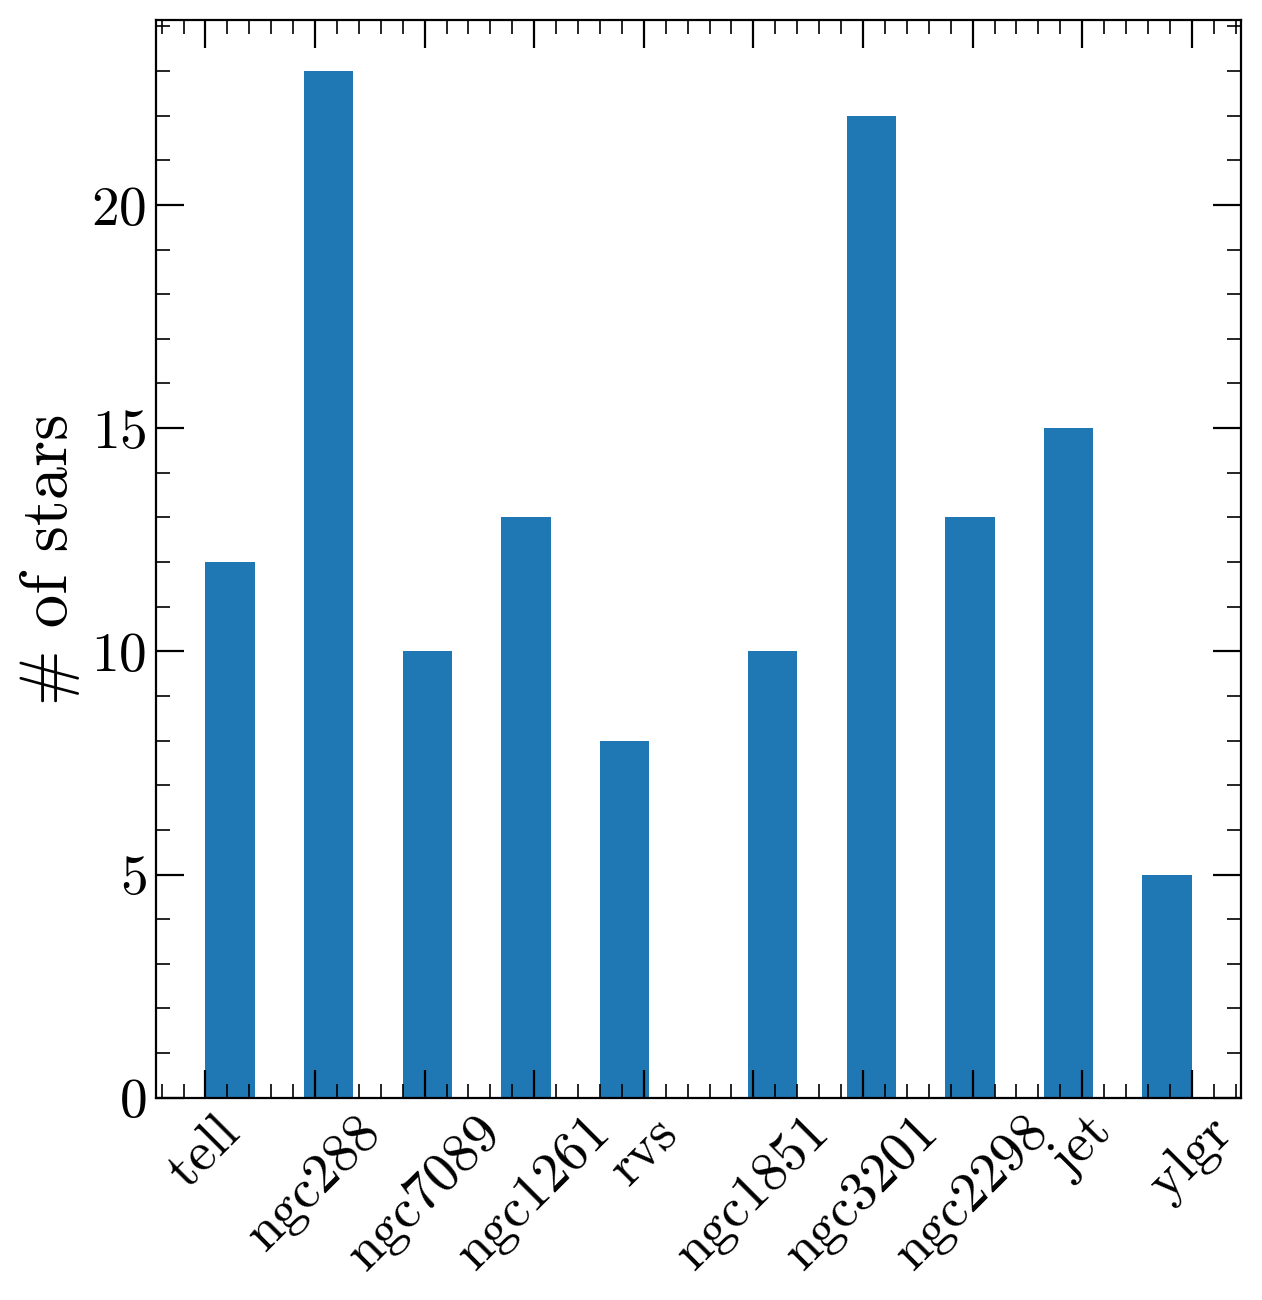

In [31]:
plt.hist(mage[bonaca]['tdb_selection'], bins = 20)
plt.xticks(rotation=45, ha = 'center')

plt.ylabel('# of stars')

In [36]:
mage[bonaca].write('/Users/vedantchandra/0_research/data/mage/catalogs/mage_bonaca_rcat_%s.fits' % version,
                  overwrite = True)

### Survey Progress

In [37]:
mage['year'] = Time(mage['mage_mjd'], format = 'mjd').jyear

In [38]:
last_time = Time(mage['mage_mjd'], format = 'mjd').iso[-1][:10]

In [39]:
title = 'MagE (%s)' % last_time

In [42]:
clean = (

    (mage['Vrot'] < 100)&
    (mage['tdb_selection'] != 'kd6')&
    (mage['tdb_selection'] != 'rvs')&
    (mage['tdb_selection'] != 'cra2')&
    (mage['tdb_selection'] != 'sxt')&
    (mage['tdb_selection'] != 'tell')&
    (mage['tdb_selection'] != 'eri')&
    (mage['tdb_selection'] != 'h3')&
    (mage['tdb_selection'] != 'pictdg')&
    (mage['tdb_selection'] != 'pscdg')&
    ~bonaca

)

print(len(clean))
print(np.sum(clean))

603
362


In [43]:
np.unique(mage[clean]['tdb_selection'])

d100
d80
d90
newpsc
pscpl1
pscpl2
pscpl3


In [44]:
d10 = clean & (mage['Dist'] > 10)
d50 = clean & (mage['Dist'] > 50)
d100 = clean & (mage['Dist'] > 100)


print(np.sum(d10))
print(np.sum(d50))
print(np.sum(d100))

293
250
98


In [45]:
def get_obscurve(tab):
    cts,obsdates = np.histogram(tab['mage_mjd'], bins = 10000, 
                                range = (mage['mage_mjd'].min(), 
                                         mage['mage_mjd'].max()))
    times = Time(obsdates, format = 'mjd')
    years = times.jyear
    
    return years[:-1], np.cumsum(cts)

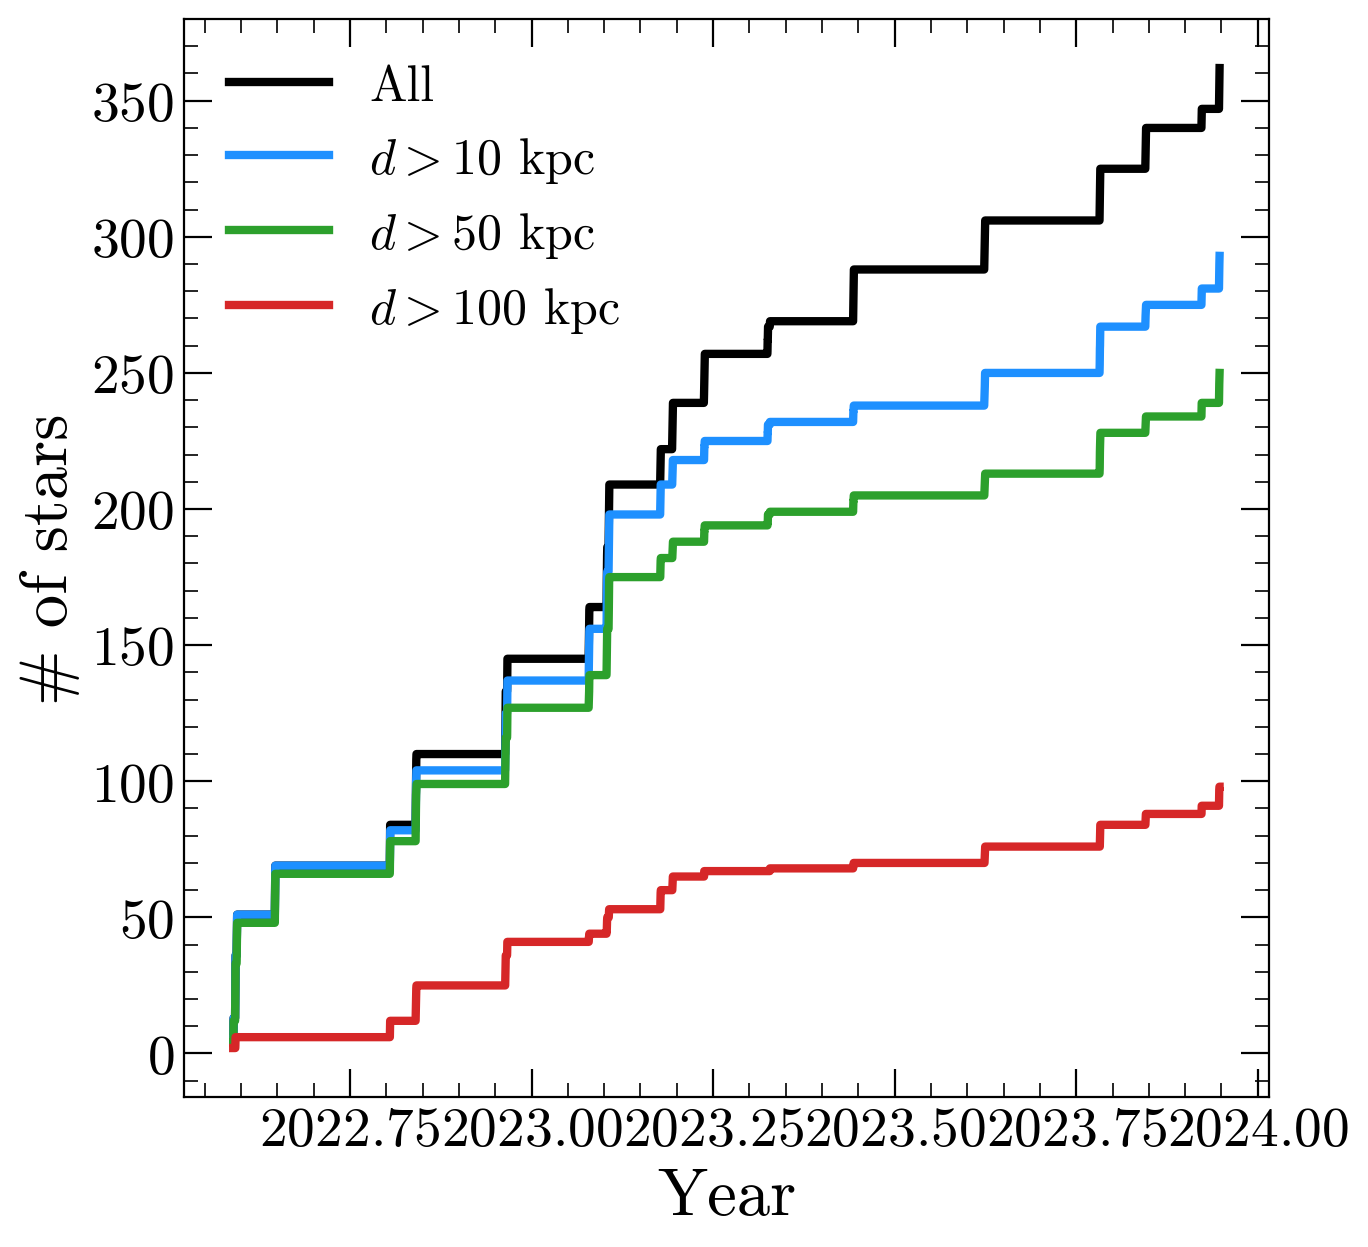

In [46]:
plt.plot(*get_obscurve(mage[clean]), color = 'k', lw = '3', label = 'All')
plt.plot(*get_obscurve(mage[d10]), color = 'dodgerblue', lw = '3', label = '$d > 10$ kpc')
plt.plot(*get_obscurve(mage[d50]), color = 'C2', lw = '3', label = '$d > 50$ kpc')
plt.plot(*get_obscurve(mage[d100]), color = 'C3', lw = '3', label = '$d > 100$ kpc')

plt.xlabel('Year')
plt.ylabel('# of stars')

plt.legend(loc = 'upper left', framealpha = 0)
#plt.title(title)

#plt.savefig('fig/cumulative_nstars.pdf')

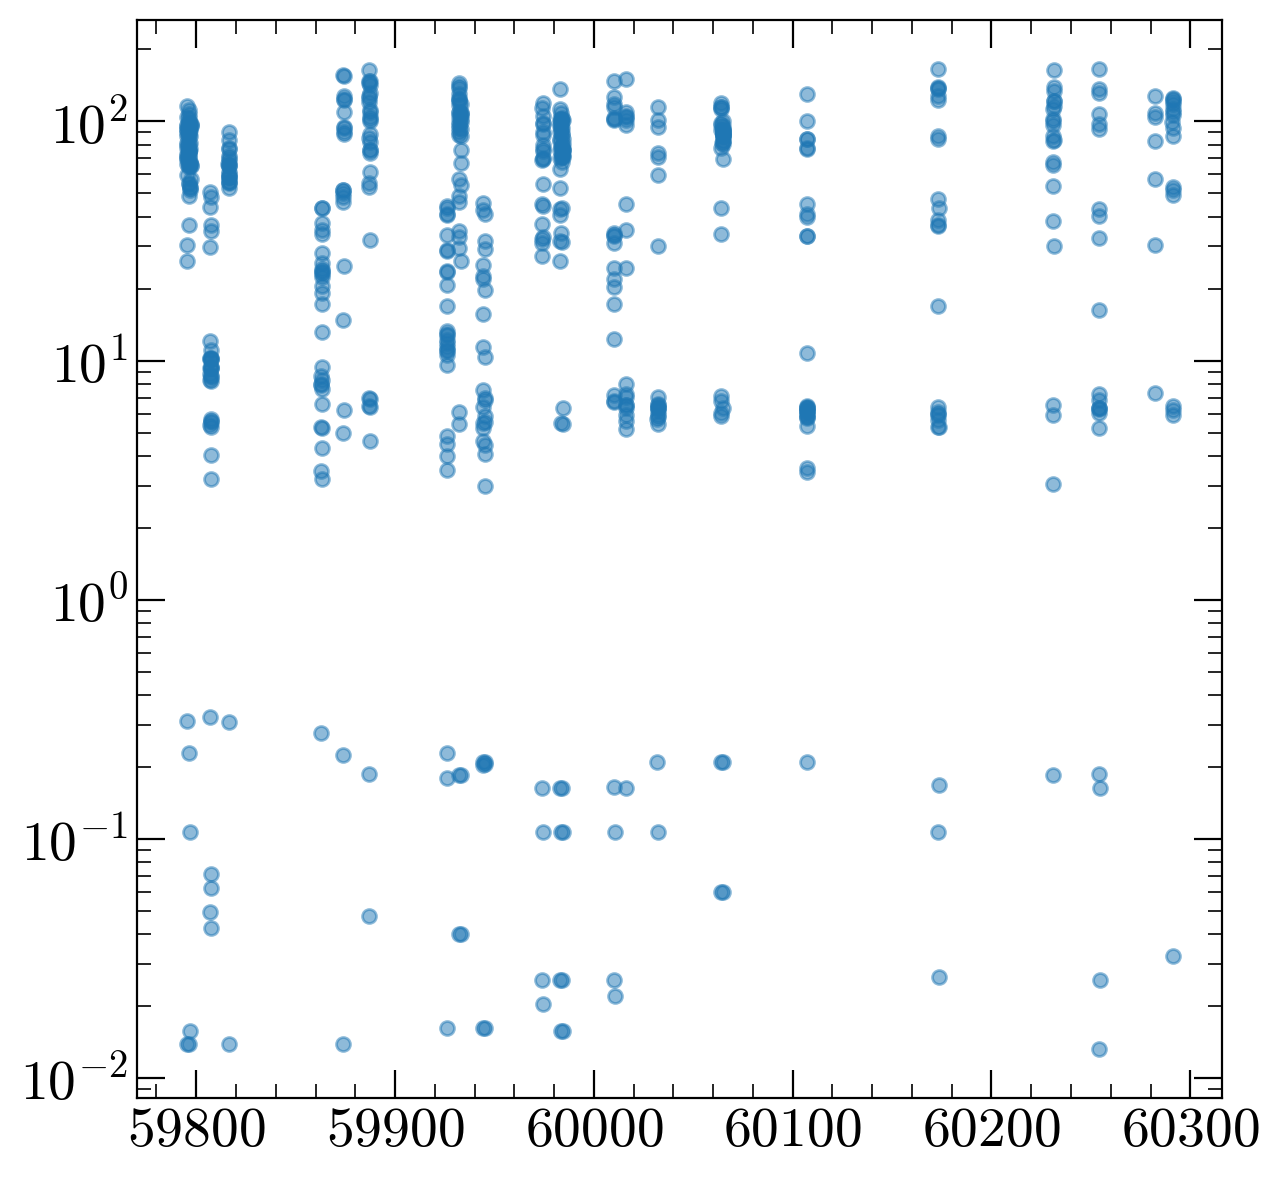

In [47]:
plt.scatter(mage['mage_mjd'], mage['Dist'], alpha = 0.5)
plt.yscale('log')

In [48]:
mage['Dist'] > 10

masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True,
                   True, False, False, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, False,
                   False, False, False, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True,
                   True, False, False, False, False, True, True, False,
                   True, False, True, True, True, True, False, False,
                   True, False, True, True, True, False, False, False,
                   False, False, False, False, False, True, False, True,
                   False, False, False, True, True, True, True, True,
                   True, True, True, True, True, True, True, True, True,
                   True, True, True, True, True, True, False

### Targeting Purity

In [49]:
np.unique(mage['tdb_selection'])

cra2
d100
d80
d90
eri
h3
jet
kd6
newpsc
...
pscdg


In [50]:
datesel = 

SyntaxError: invalid syntax (610663252.py, line 1)

In [51]:
d100sel = mage['tdb_selection'] == 'd100'

In [52]:
np.sum(d100sel & d50) / np.sum(d100sel)

0.5843137254901961

In [53]:
l_labs = [0, 300, 240, 120, 60]
locs = [0, 0.68, 1.35, -1.65, -0.95]

b_labs = [-60, -30, 30, 60]
blocs = [[-1.55, -0.85], [-2., -0.55], [-1.9, 0.45], [-1.5, 0.75]]

def add_labels(ax):
    for kk in range(len(l_labs)):
        ax.annotate(str(l_labs[kk]), xy = [locs[kk], 0], xytext = [5, 5],
           xycoords = 'data', textcoords = 'offset points',
                   fontsize = 18)
        
    for kk in range(len(b_labs)):
        ax.annotate(str(b_labs[kk]), xy = blocs[kk], xytext = [-5, 5],
           xycoords = 'data', textcoords = 'offset points',
                   fontsize = 18)

In [54]:
smc = dict(ra = 013.1583, dec = -72.8003,
          pmra = 0.772, pmdec = -1.117,
          rv = 145.6,
          distance = 62)

lmc = dict(ra = 080.8942, dec = -69.7561,
          pmra = 1.910, pmdec = 0.229,
          rv = 262.2, distance = 50)

clouds = Table([lmc, smc])
cloud_kw = dict(color = 'royalblue', s = [450, 350], marker = '*', edgecolor = 'k',
               lw = 1.5)
clouds = oh.make_coords(clouds)

In [55]:
mss = Table.read("/Users/vedantchandra/0_research/00_outerhalo/06_mage/01_plume/txt/mss.fits")

In [56]:
dsel = d100targ['dec'] < 10

NameError: name 'd100targ' is not defined

In [57]:
l1 = -150
l2 = 33

b20 = SkyCoord(l = np.linspace(l1, l2, 1000) * u.deg, b = np.repeat(20, 1000) * u.deg,
              frame = 'galactic')

l1 = -170
l2 = 55
bm20 = SkyCoord(l = np.linspace(l1, l2, 1000) * u.deg, b = np.repeat(-20, 1000) * u.deg,
              frame = 'galactic')

In [25]:
d100sel = clean & (mage['tdb_selection'] == 'd100')

In [26]:
from astropy.io import ascii

lmco = ascii.read('/Users/vedantchandra/0_research/data/lit/ngc21_LMC_orbit.txt')

/Users/vedantchandra/opt/miniconda3/envs/outerhalo/lib/python3.8/site-packages/healpy/projaxes.py:377: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  s = self.scatter(x, y, *args, **kwds)



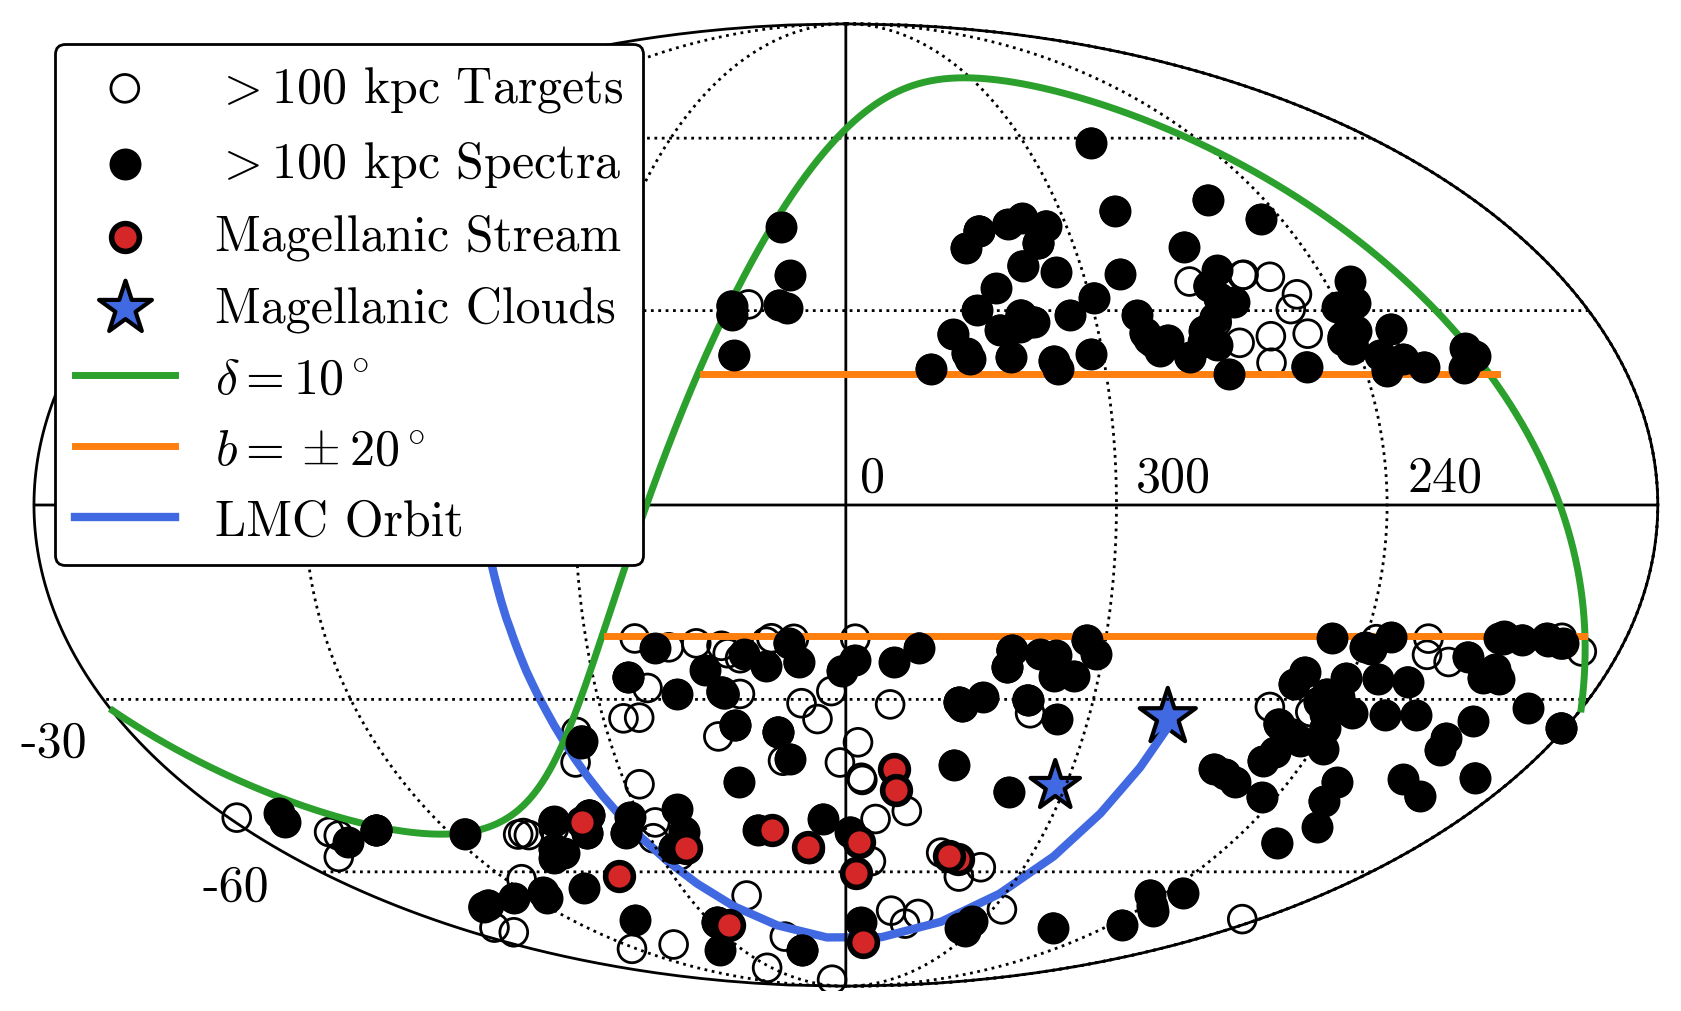

In [27]:
d0 = SkyCoord(ra = np.linspace(0, 360, 1000) * u.deg, dec = np.repeat(10, 1000) * u.deg).galactic

hp.mollview()
hp.graticule(dmer = 60)

hp.projscatter(d100targ['l'][dsel], d100targ['b'][dsel], lonlat = True,
              label = '$> 100$ kpc Targets', marker = 'o', facecolor = 'none', 
              edgecolor = 'k', s = 100)


# im = hp.projscatter(mage[clean]['L'], mage[clean]['B'], lonlat = True, 
#               c = mage[clean]['year'], cmap = 'viridis', edgecolor = 'k', 
#                    s = 100, label = 'MagE Spectra', zorder = 3,
#                    lw = 1.5)

hp.projscatter(mage[clean&d100sel]['L'], mage[clean&d100sel]['B'], lonlat = True, 
             color = 'k', cmap = 'viridis', edgecolor = 'k', 
                   s = 100, label = '$>100$ kpc Spectra', zorder = 3,
                   lw = 1.5)

hp.projscatter(mss['l'], mss['b'], lonlat = True, 
              s = 100, edgecolor = 'k', zorder = 4, facecolor = 'C3', lw = 2,
              label = 'Magellanic Stream')

hp.projscatter(clouds['l'], clouds['b'], lonlat = True, **cloud_kw, label = 'Magellanic Clouds')

hp.projplot(d0.l, d0.b, lonlat = True, color = 'C2', label = '$\delta = 10^\circ$', lw = 2.5)
hp.projplot(b20.l, b20.b, color = 'C1', lonlat = True, label = '$b = \pm 20^\circ$', lw = 2.5)
hp.projplot(bm20.l, bm20.b, color = 'C1', lonlat = True,  lw = 2.5)

hp.projplot(lmco['col4'], lmco['col5'], lonlat = True, lw = 3, 
           color = 'royalblue', label = "LMC Orbit", zorder = 1.5);

plt.legend(loc = 'upper left')

# cbar = plt.colorbar(im, location = 'bottom', orientation = 'horizontal',
#             fraction = 0.05, pad = 0.05)
plt.title('')
# cbar.ax.set_xlabel('Year')

ax = plt.gca()
add_labels(ax)

#plt.savefig('fig/d100_progress_map.pdf')

In [28]:
np.sum(clean)

338

In [29]:
np.sum(clean & (mage['Dist'] > 100))

87

In [30]:
np.sum(clean & (mage['Dist'] > 50))

231

In [31]:
dobs = np.isin(d100targ['source_id'], mage['tdb_source_id'])

In [32]:
np.sum(dobs & dsel)

211

In [33]:
obs = np.isin(mage['tdb_source_id'], d100targ['source_id'])

In [34]:
np.sum(dobs & dsel)

211

In [35]:
np.sum(clean & obs)

217

In [36]:
np.sum(clean & obs & (mage['Dist'] > 100)), np.sum(clean & obs & (mage['Dist'] > 50))

(71, 131)

In [37]:
62 / 125

0.496

In [38]:
100 / 125

0.8

In [39]:
np.sum(dsel) - np.sum(dobs & dsel)

73

In [40]:
(np.sum(dsel) - np.sum(dobs & dsel)) / 18

4.055555555555555

In [41]:
from astropy.coordinates import Angle

In [42]:
def mkquants(x):
    return np.array([np.quantile(x, 0.05), np.quantile(x, 0.5), np.quantile(x, 0.95)])

In [43]:
left = d100targ[dsel & ~dobs]

In [44]:
Angle(mkquants(left['RA']) * u.deg).hms

hms_tuple(h=array([ 1., 20., 23.]), m=array([16.,  2., 37.]), s=array([35.03715222, 17.60513493, 56.08441234]))

In [45]:
Angle(mkquants(left['DEC']) * u.deg)

<Angle [-50.85761689, -17.34193728,   6.01395037] deg>

In [46]:
mkquants(left['phot_g_mean_mag'])

array([17.57309761, 18.27486229, 18.47418594])

In [47]:
def gtrhist(x, dbins):
    counts = [];

    for ii in range(len(dbins)):
        di = dbins[ii]
        counts.append(np.sum(x > di))

    counts = np.array(counts)
    
    return counts

dbins = np.linspace(1, 160, 100)

In [48]:
nstar_mage = gtrhist(mage[clean]['Dist'], dbins)
nstar_h3 = gtrhist(h3['h3_dist_adpt'][hgiants], dbins)
# nstar_gaia = gtrhist(tab2['r_med_geo'] / 1000, dbins)

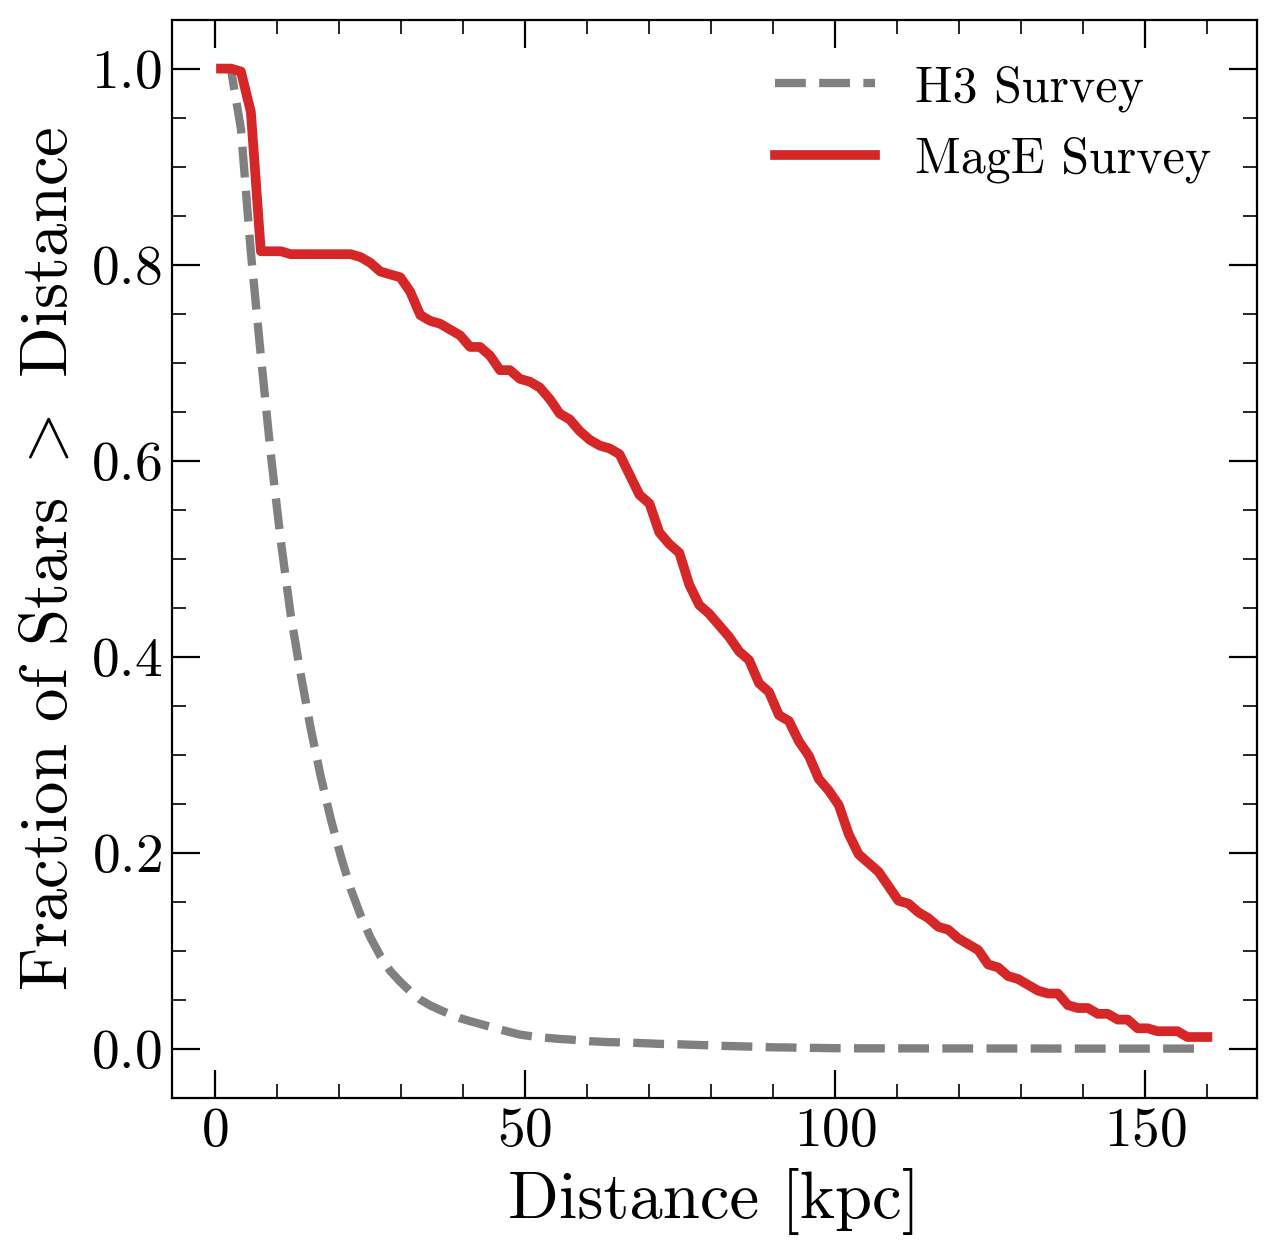

In [49]:
# plt.plot(dbins, nstar_gaia / np.max(nstar_gaia), color = 'darkgray', lw = 2.5, ls = ':', label = 'Gaia DR3')
plt.plot(dbins, nstar_h3 / np.max(nstar_h3), color = 'gray', lw = 3, ls = '--', label = 'H3 Survey')
plt.plot(dbins, nstar_mage / np.max(nstar_mage), color = 'C3', lw = 3.5, label = 'MagE Survey')



#plt.yscale('log')
#plt.xscale('log')

plt.legend(framealpha = 0)

plt.ylabel('Fraction of Stars $>$ Distance')
plt.xlabel('Distance [kpc]')

plt.savefig('fig/distance_h3comp.pdf')

### MINESweeper Parameters

In [59]:
from chandra import plot as chplot

In [60]:
field = clean & (

    (mage['tdb_selection'] == 'd100') | 
    (mage['tdb_selection'] == 'd100r') |
    (mage['tdb_selection'] == 'd90') |
    (mage['tdb_selection'] == 'd90r')
    
)

np.sum(field)

287

In [61]:
hcl = (

    (h3['h3_FLAG'] == 0)&
    (h3['h3_logg'] < 3.5) & 
    (h3['h3_SNR'] > 3)

)

Text(0.5, 0, 'Distance [kpc]')

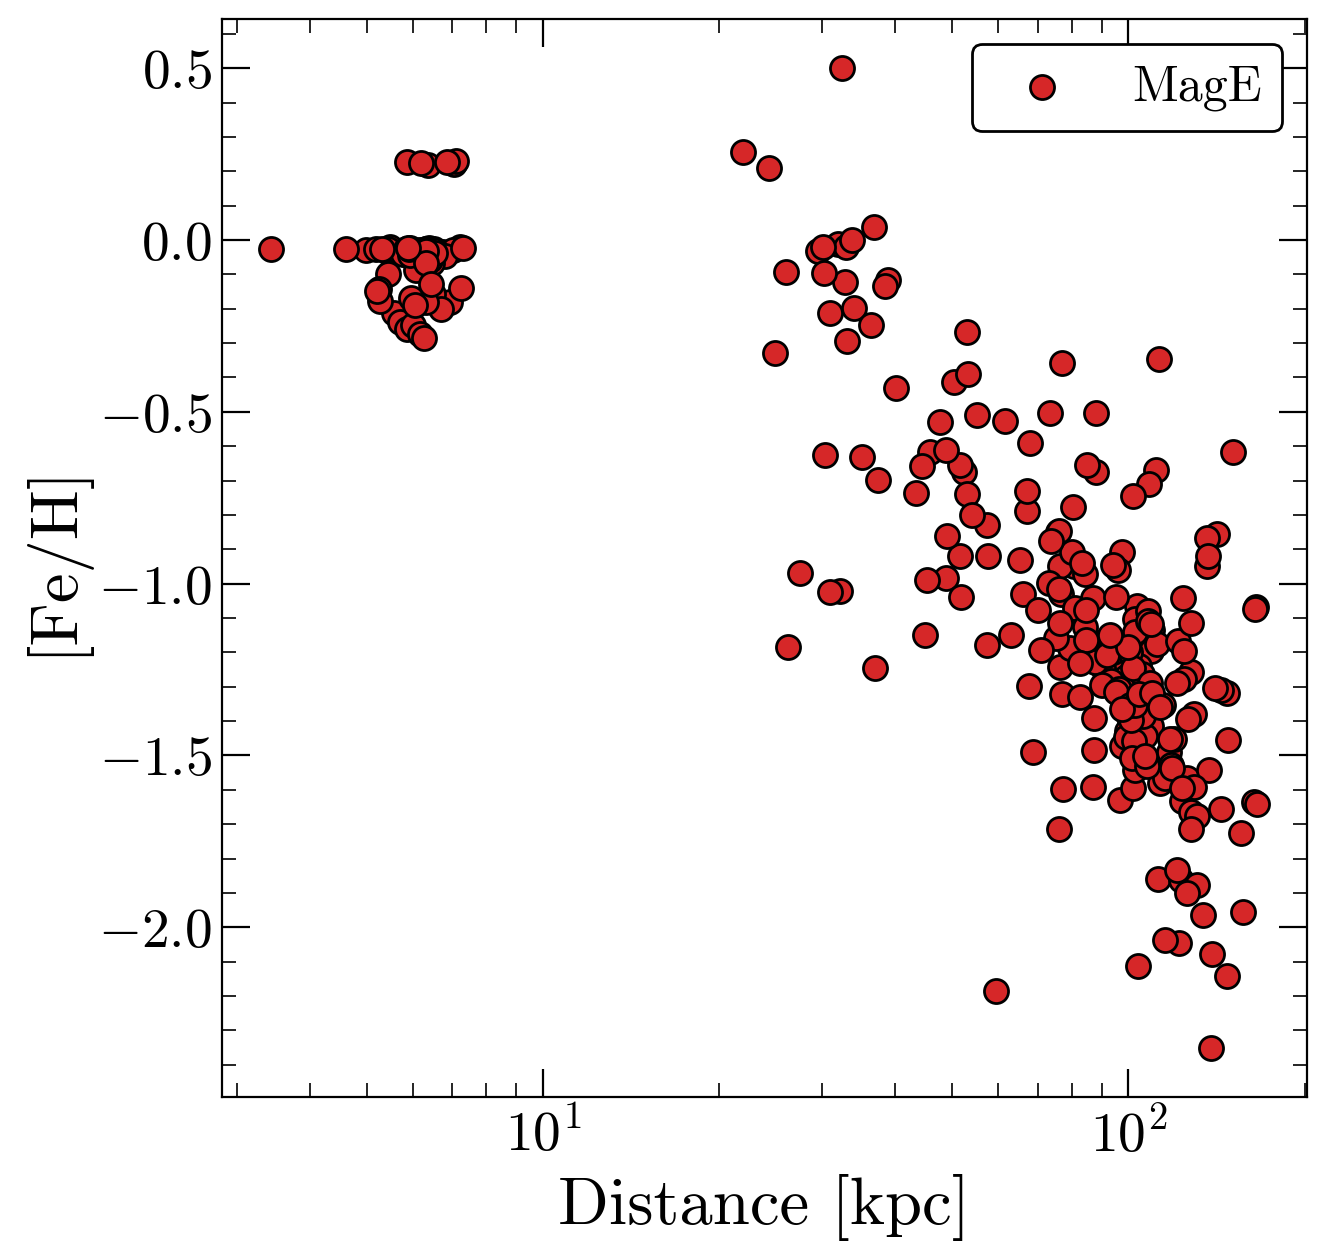

In [62]:
# chplot.hist_norm(h3['h3_dist_adpt'], h3['h3_FeH'], bins = 100, normy = True,
#                 pkw = dict(cmap = 'Greys'),
#                 rangex = [0, 160], rangey = [-2.5, 0.5],
#                 ylab = '[Fe/H]', xlab = r'Distance [kpc]');

plt.scatter(mage[clean&field]['Dist'], mage[clean&field]["FeH"], color = 'C3',  s = 75,
           edgecolor = 'k', label = 'MagE')

plt.legend(loc = 'upper right')

plt.xscale('log')

plt.ylabel('[Fe/H]')
plt.xlabel('Distance [kpc]')

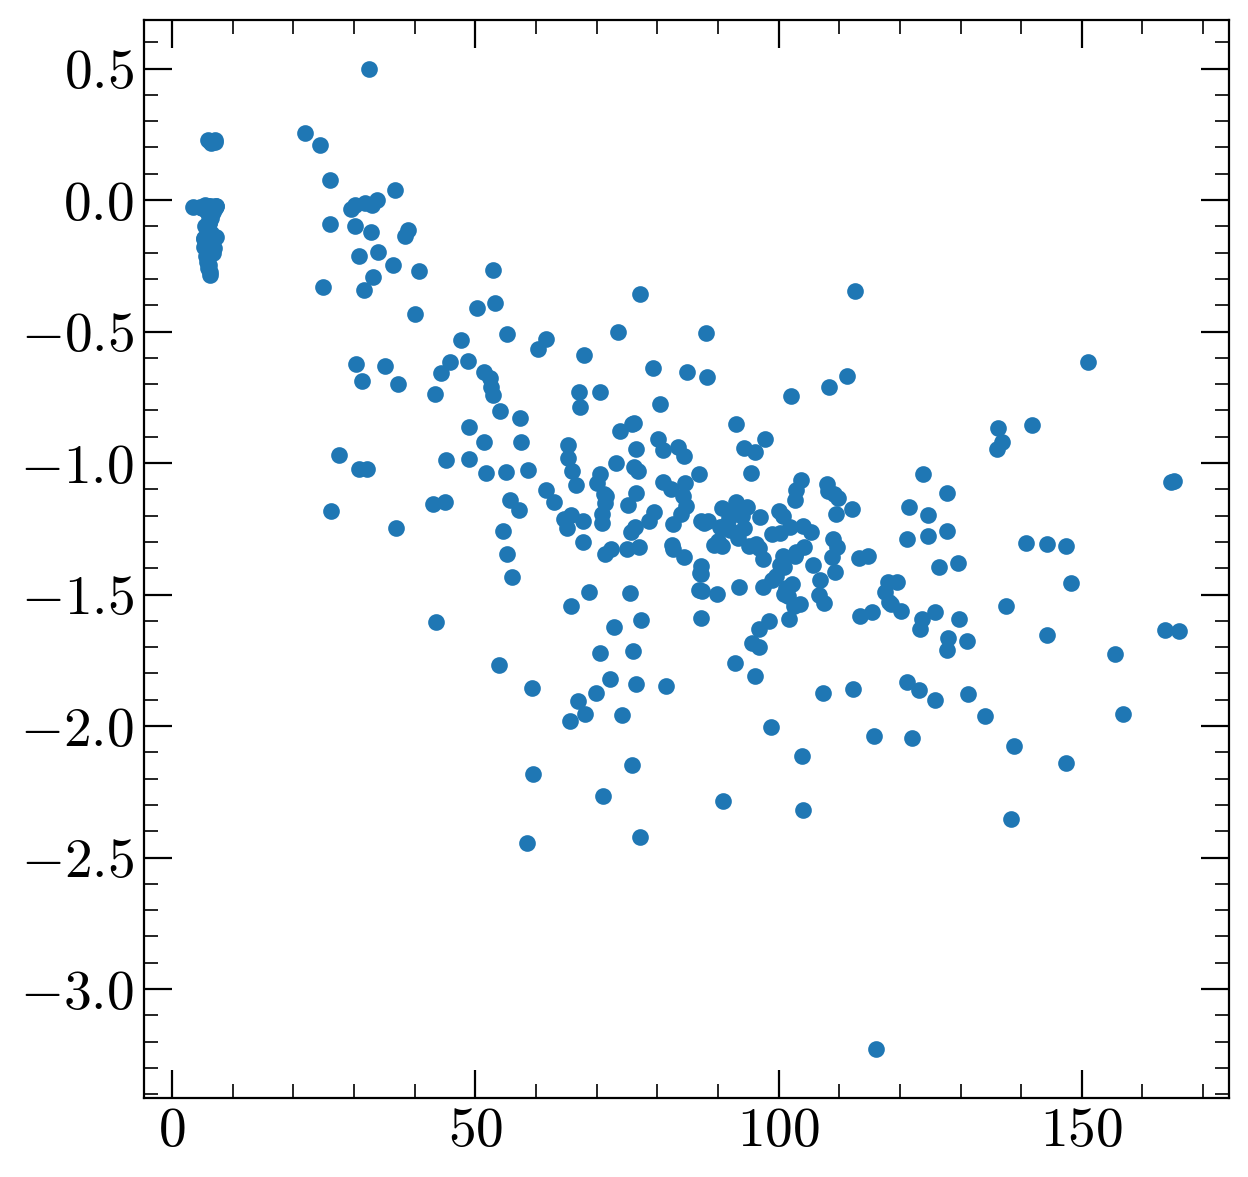

In [63]:
plt.scatter(mage[clean]['Dist'], mage[clean]["FeH"])

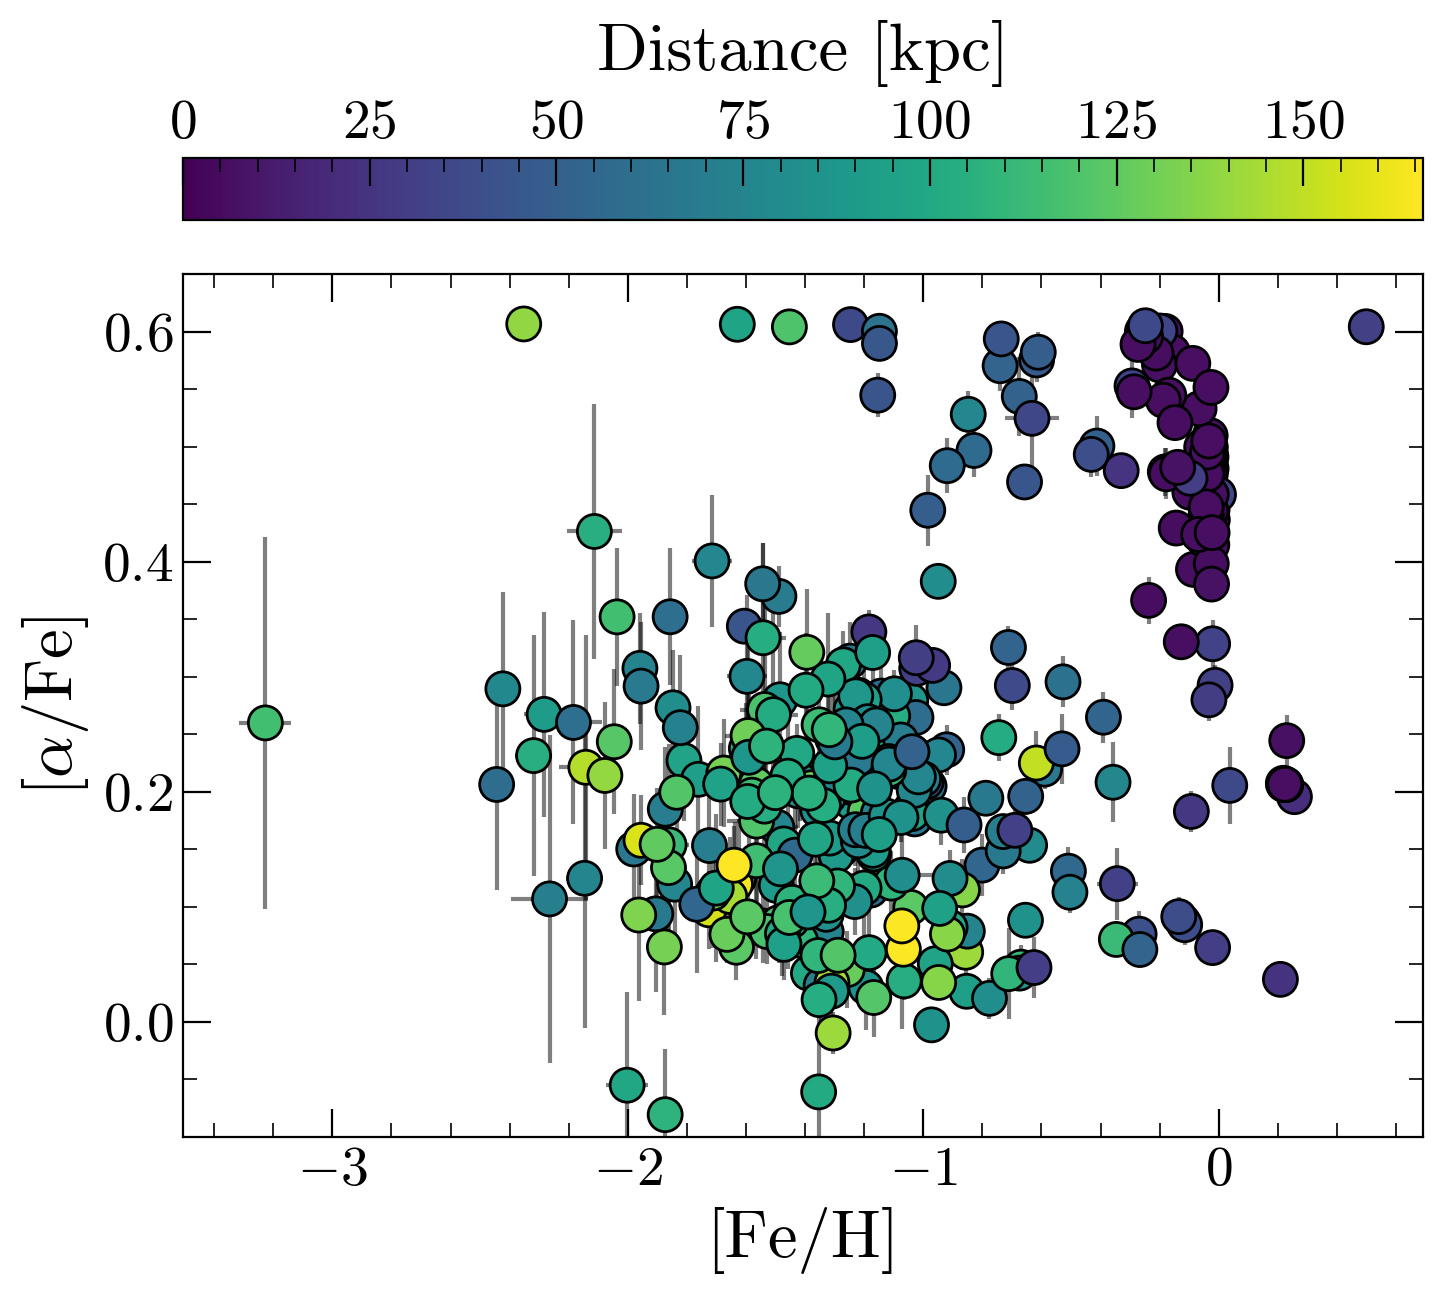

In [64]:
plt.figure(figsize = (8, 7))
plt.scatter(mage[clean]['FeH'], mage[clean]['aFe'], 
            c = mage[clean]['Dist'], cmap = 'viridis', s = 150, edgecolor = 'k',
           vmin = 0)
plt.errorbar(mage[clean]['FeH'], mage[clean]['aFe'], xerr = mage[clean]['FeH_err'],
             yerr = mage[clean]['aFe_err'], 
             linestyle = 'none', zorder = 0, ecolor = 'k', alpha = 0.5)

plt.xlabel('[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.ylim(-0.1, 0.65)
cbar = plt.colorbar(location = 'top', orientation = 'horizontal')
cbar.ax.set_xlabel('Distance [kpc]', labelpad = 10.5)

plt.savefig('fig/tw_distance.pdf')

### RV Precision

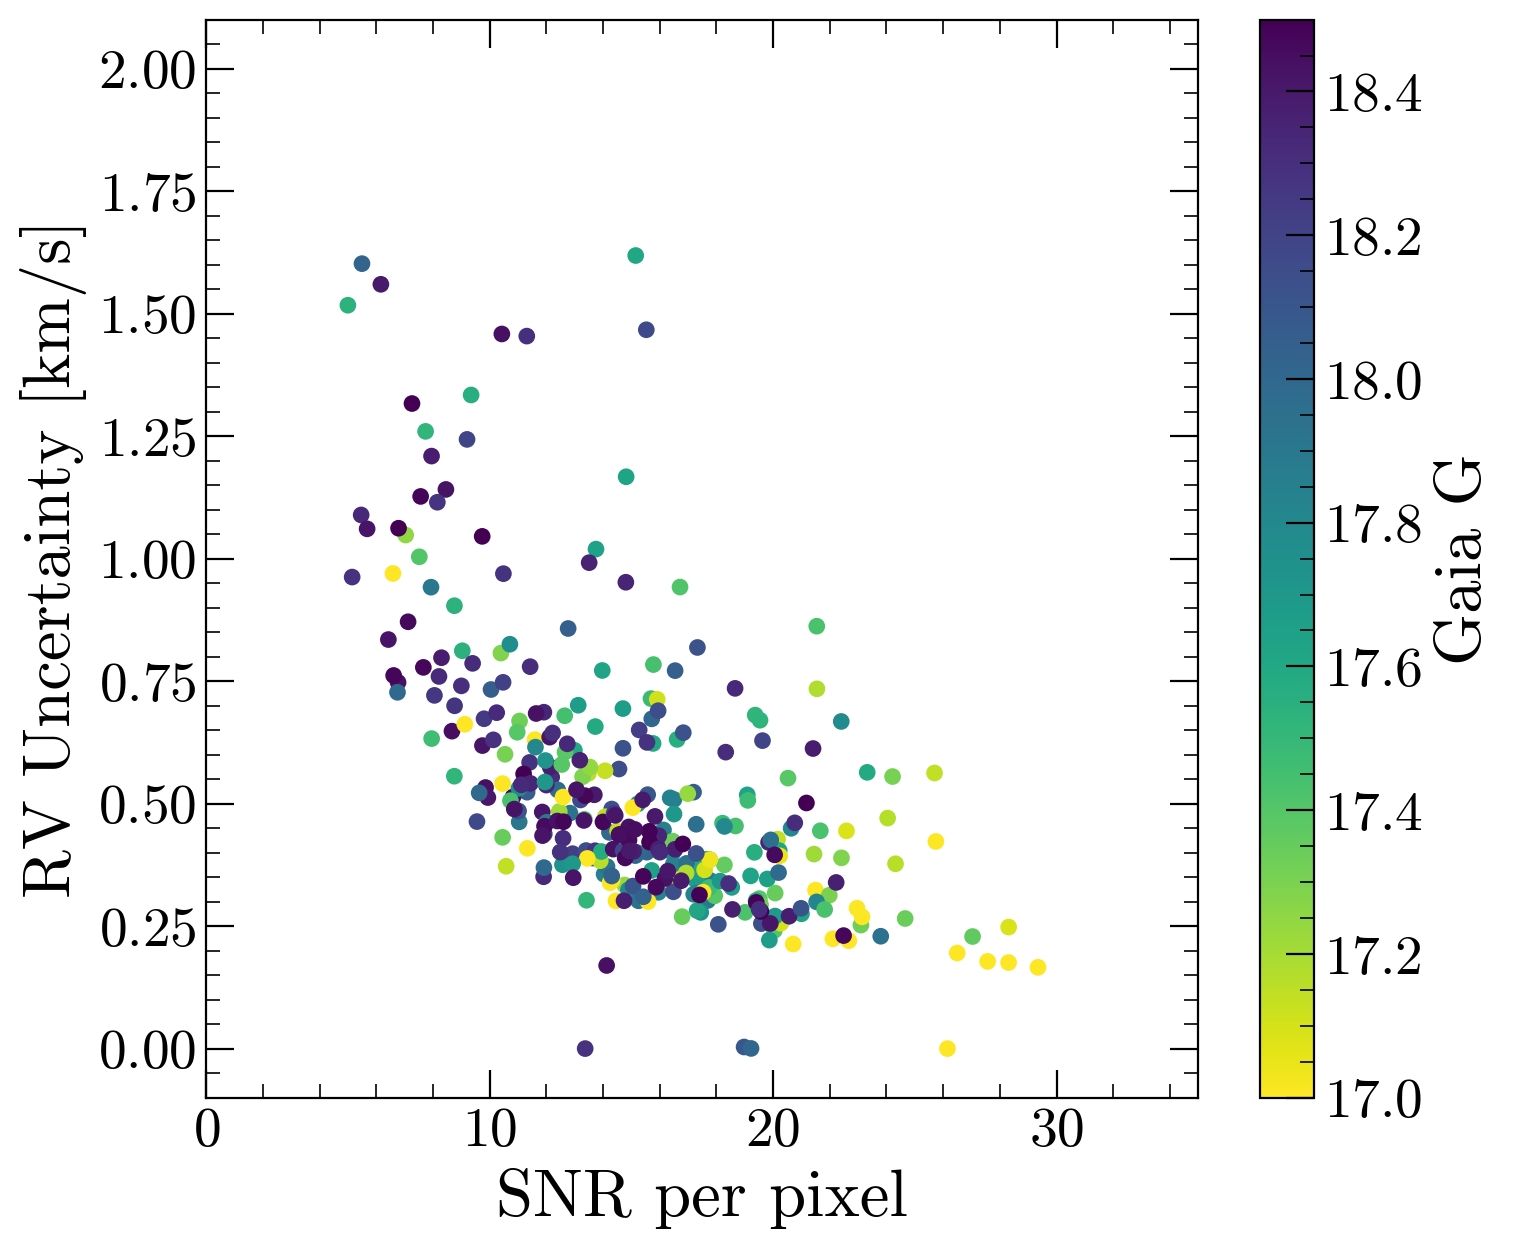

In [56]:
plt.figure(figsize = (8, 7))

plt.scatter(mage[clean]['spec_snr'], mage[clean]['Vrad_err'],
           c = mage[clean]['GAIAEDR3_G'], cmap = 'viridis_r', vmin = 17, vmax = 18.5)

plt.xlabel('SNR per pixel')
plt.ylabel('RV Uncertainty [km/s]')

cbar = plt.colorbar()
cbar.ax.set_ylabel('Gaia G')

plt.ylim(-0.1, 2.1)
plt.xlim(0, 35)

plt.savefig('fig/rv_precision.png')

In [57]:
np.sqrt(1**2 + 1**2)

1.4142135623730951

In [58]:
rvs = mage[(mage['tdb_selection'] == 'rvs')]

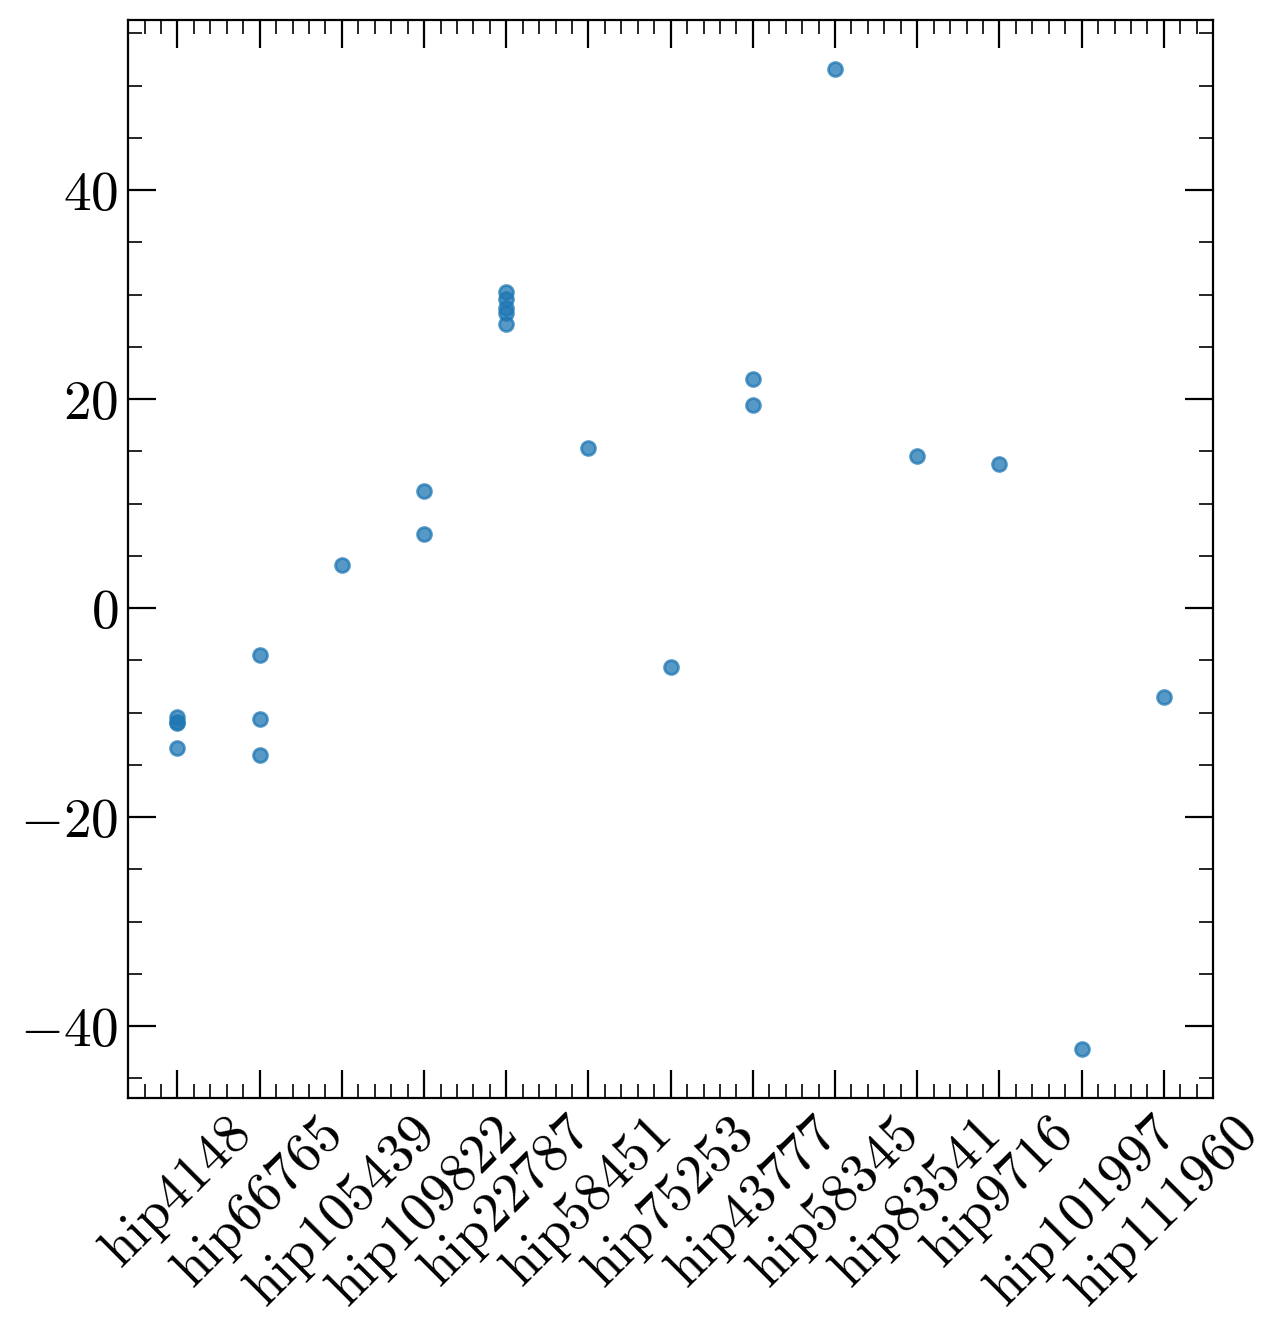

In [59]:
plt.scatter(rvs['name'], rvs['Vrad'], alpha = 0.75)
plt.xticks(rotation=45);

In [60]:
def eval_rvs(rvstar):

    std_rv = rvstar['Vrad']
    std_rv_err = rvstar['Vrad_err']
    std_rv_mu = np.average(std_rv, weights = 1/std_rv_err**2)

    std_rv_std = np.std(std_rv)

    std_rv_rms = np.sqrt(np.mean((std_rv - std_rv_mu)**2))

    nday = rvstar['mage_mjd'].max() - rvstar['mage_mjd'].min()

    plt.hist(rvstar['Vrad'] - std_rv_mu, range = (-5, 5), bins = 50);

    plt.title(rvstar['name'][0] + ' (G = %.1f, %i days)' % (rvstar['GAIAEDR3_G'][0], nday))

    plt.text(0.95, 0.95, 'rms = %.1f km/s' % std_rv_rms, transform = plt.gca().transAxes,
            ha = 'right', va = 'top')

    plt.ylim(0, 2.5)

    plt.ylabel('# of RVs')
    plt.xlabel(r'RV - $\langle \mathrm{RV} \rangle$ [km/s]')

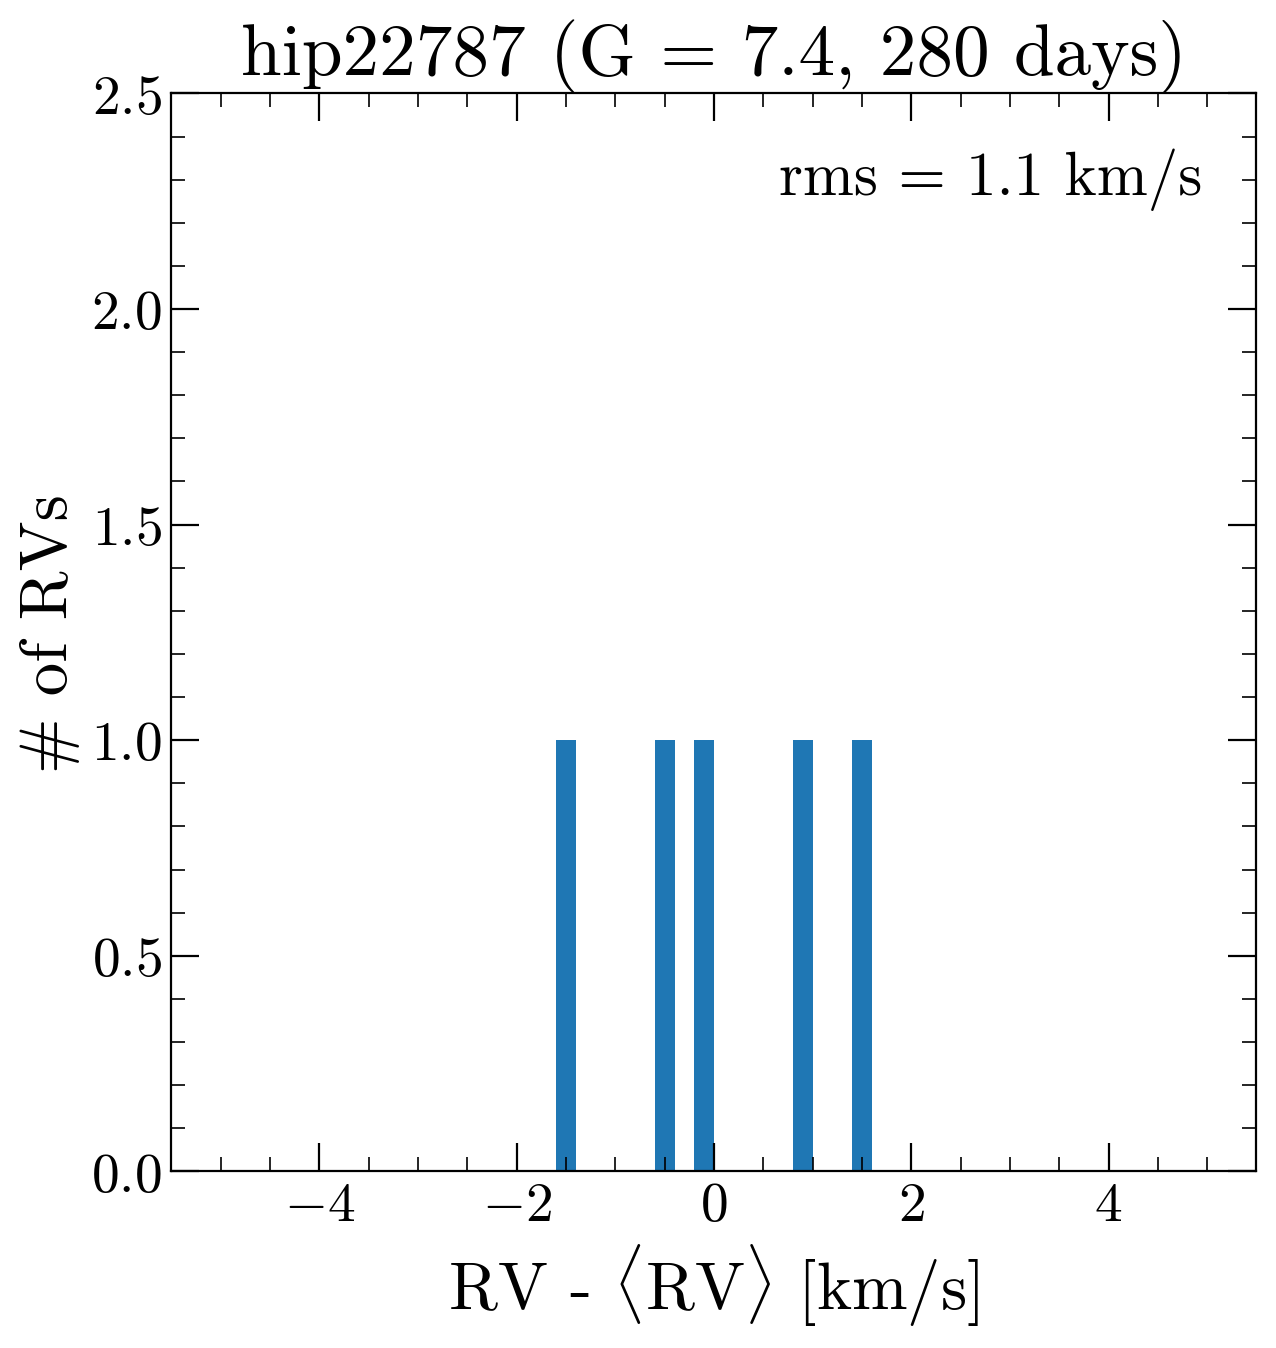

In [61]:
eval_rvs(mage[mage['name'] == 'hip22787'])
plt.savefig('fig/rvs_hip22787.png')

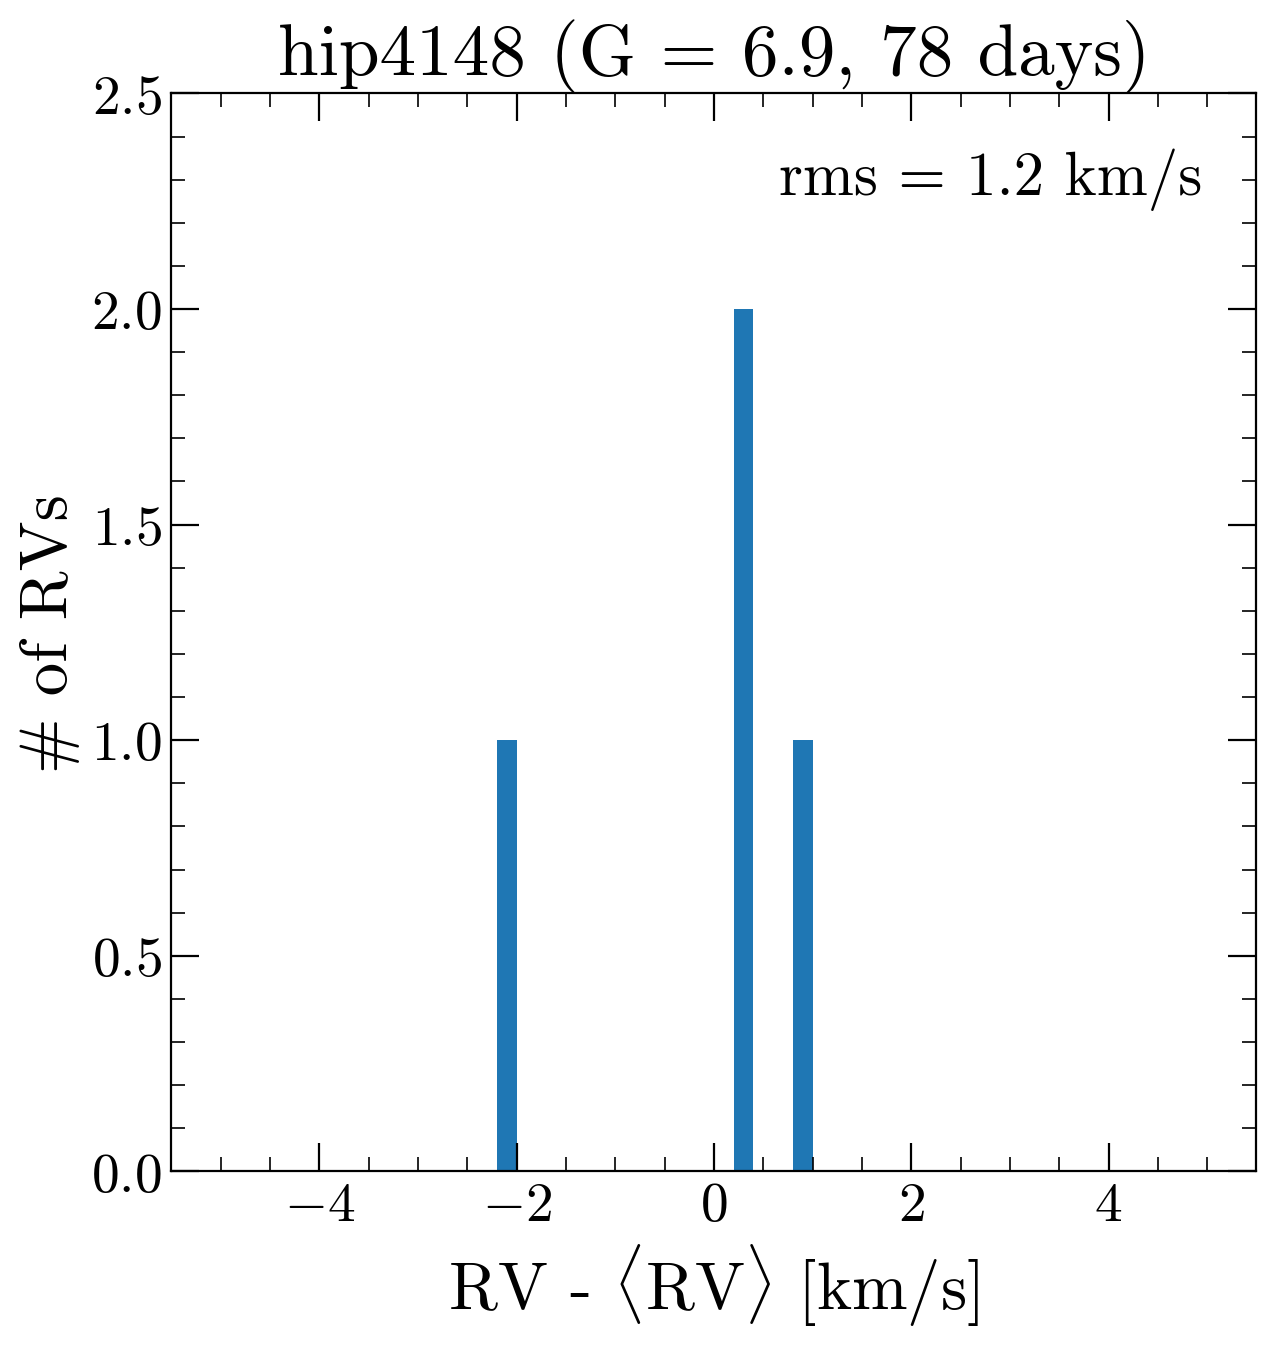

In [62]:
eval_rvs(mage[mage['name'] == 'hip4148'])
plt.savefig('fig/rvs_hip4148.png')

### Comparison To H3

In [63]:
h3['GAIAEDR3_ID'] = h3['h3_GAIAEDR3_ID']

In [64]:
table = astropy.table.join(mage, h3, keys = 'GAIAEDR3_ID', join_type = 'left')

In [65]:
table['h3_Dist'] = table['h3_dist_adpt']
table['h3_Dist_err'] = table['h3_dist_adpt_err']

In [66]:
cl = (

    (table['h3_FLAG'] == 0)&
    (table['Vrot'] < 100)

)

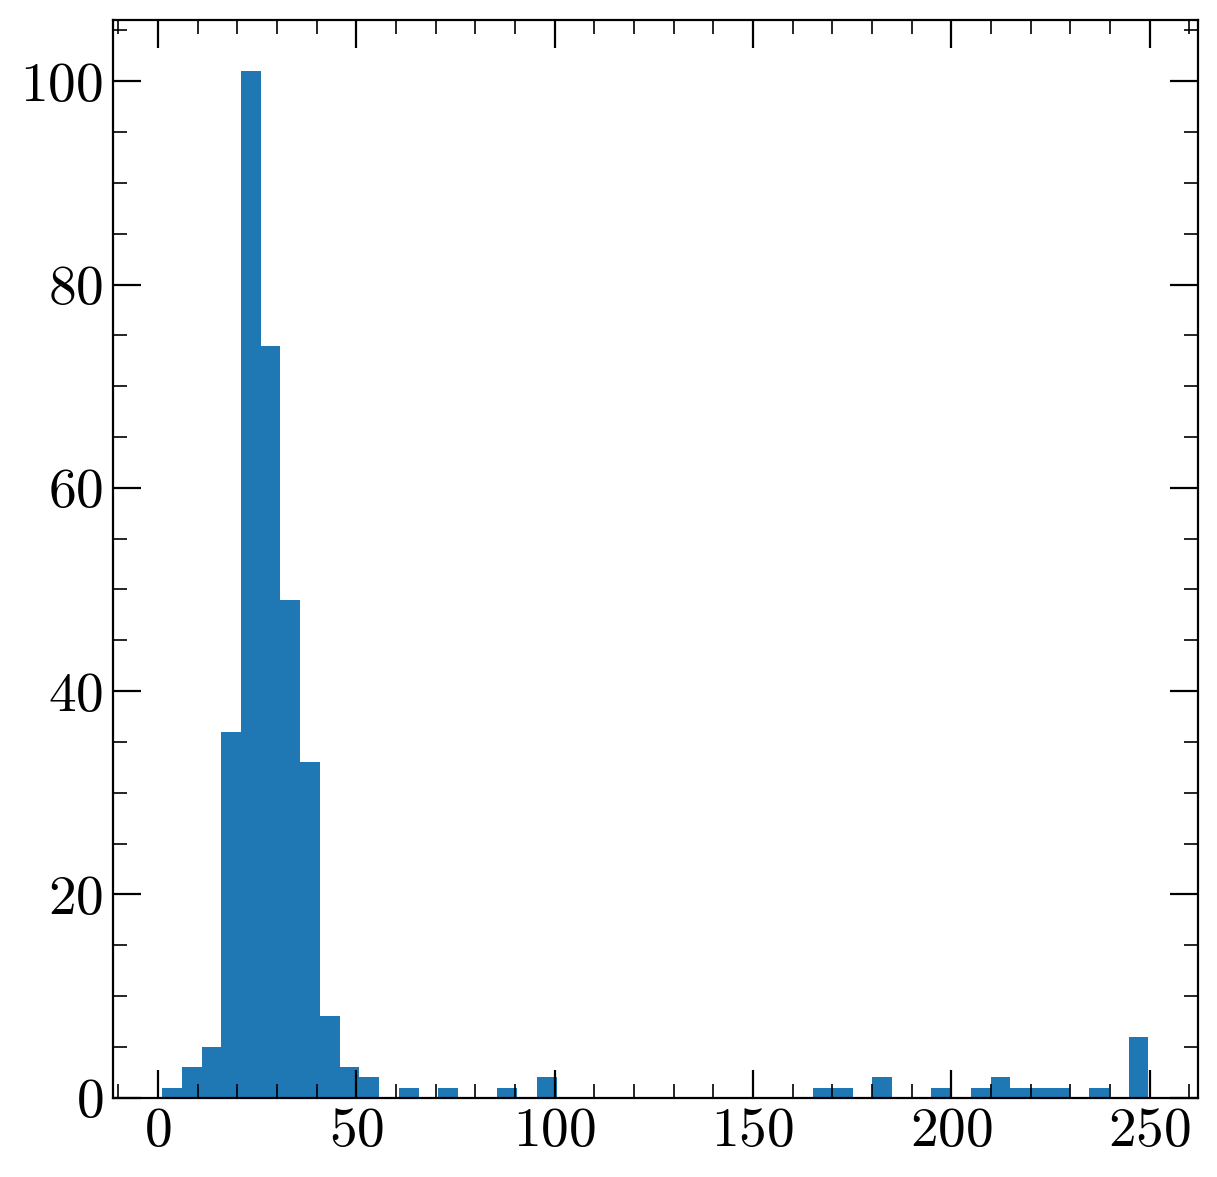

In [67]:
plt.hist(table[clean]['Vrot'], bins = 50);

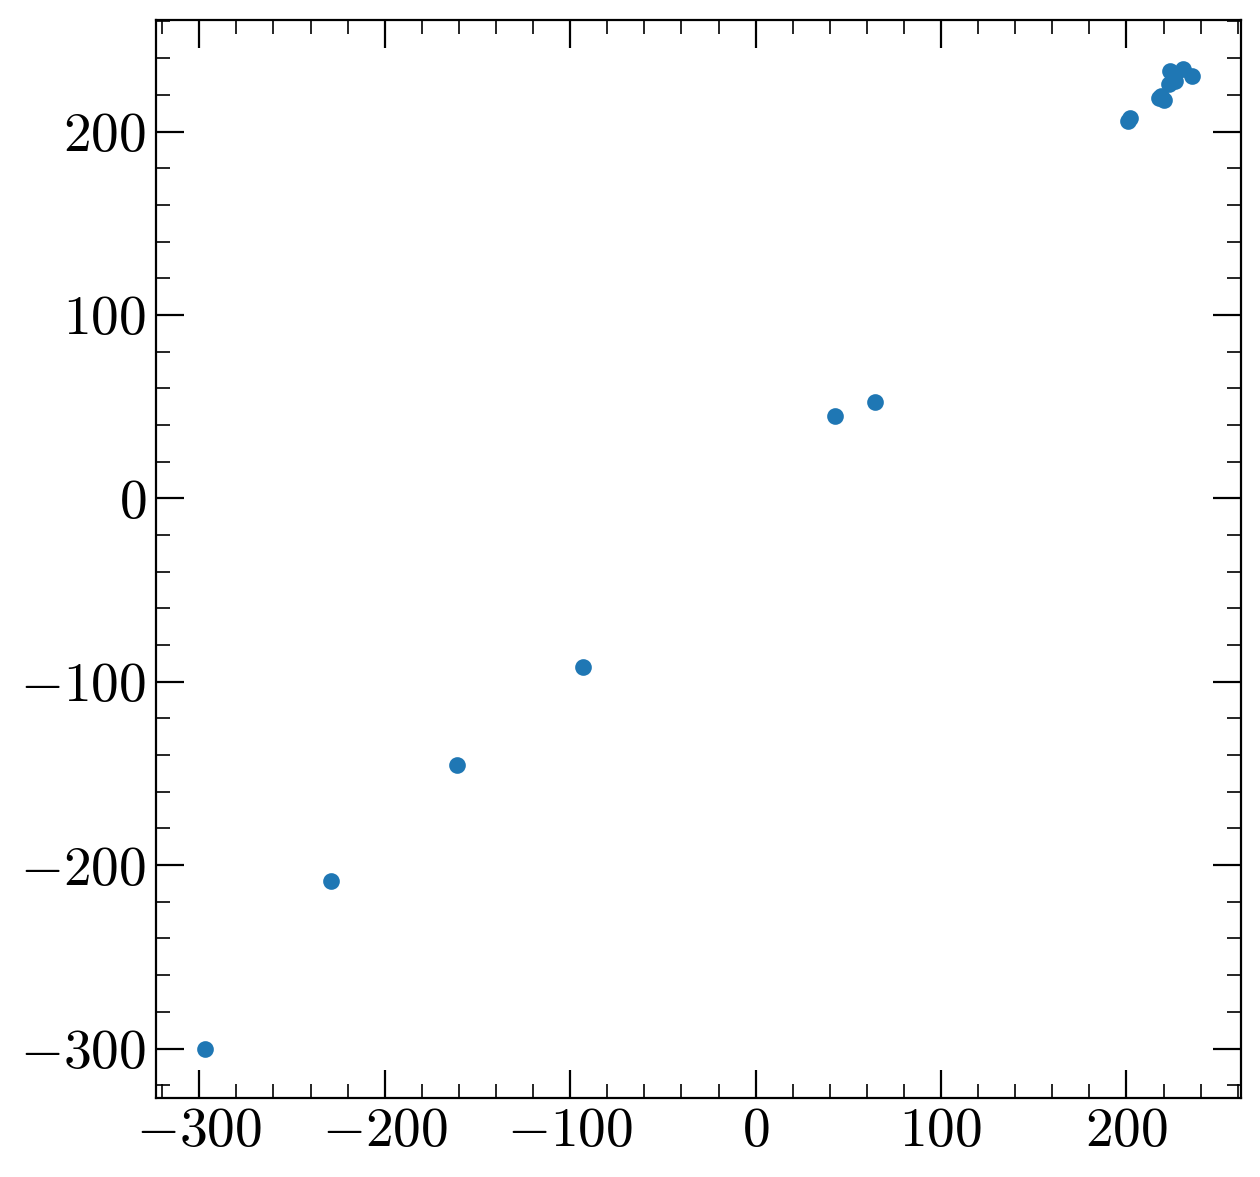

In [68]:
plt.scatter(table['h3_Vrad'][clean], table['Vrad'][clean])

In [69]:
ekw = dict(linestyle = 'none', marker = 'o', color = 'k', ecolor = 'gray', capsize = 0)
fs = 22

In [70]:
def comp(x):
    mins = np.nanmin([np.nanmin(table['h3_' + x][clean]), 
                                 np.nanmin(table[x][clean])])
    maxs = np.nanmax([np.nanmax(table['h3_' + x][clean]), 
                                 np.nanmax(table[x][clean])])
    lims = [mins - 0.1 * np.abs(mins), maxs + 0.1 * np.abs(maxs)]
    
    diff =  table[x][clean] - table['h3_' + x][clean]
    
    mad = np.median(np.abs(diff))
    bias = np.median(diff)

    plt.errorbar(table['h3_' + x][clean], table[x][clean],
                xerr = table['h3_' + x + '_err'][clean], yerr = table[x + '_err'][clean], **ekw)

    plt.plot(lims, lims, 'C3')
    plt.title('MAD: %.2f, Bias: %.2f' % (mad, bias), fontsize = fs)
    
    plt.xlim(lims)
    plt.ylim(lims)
    
    #if x == 'Dist':
    #    plt.xscale('log')
    #    plt.yscale('log')

/Users/vedantchandra/opt/miniconda3/envs/outerhalo/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)

/var/folders/6d/8w3sw49j3715htmfyjnsf0zh0000gn/T/ipykernel_1783/1019202934.py:17: UserWarning: Warning: converting a masked element to nan.
  plt.title('MAD: %.2f, Bias: %.2f' % (mad, bias), fontsize = fs)



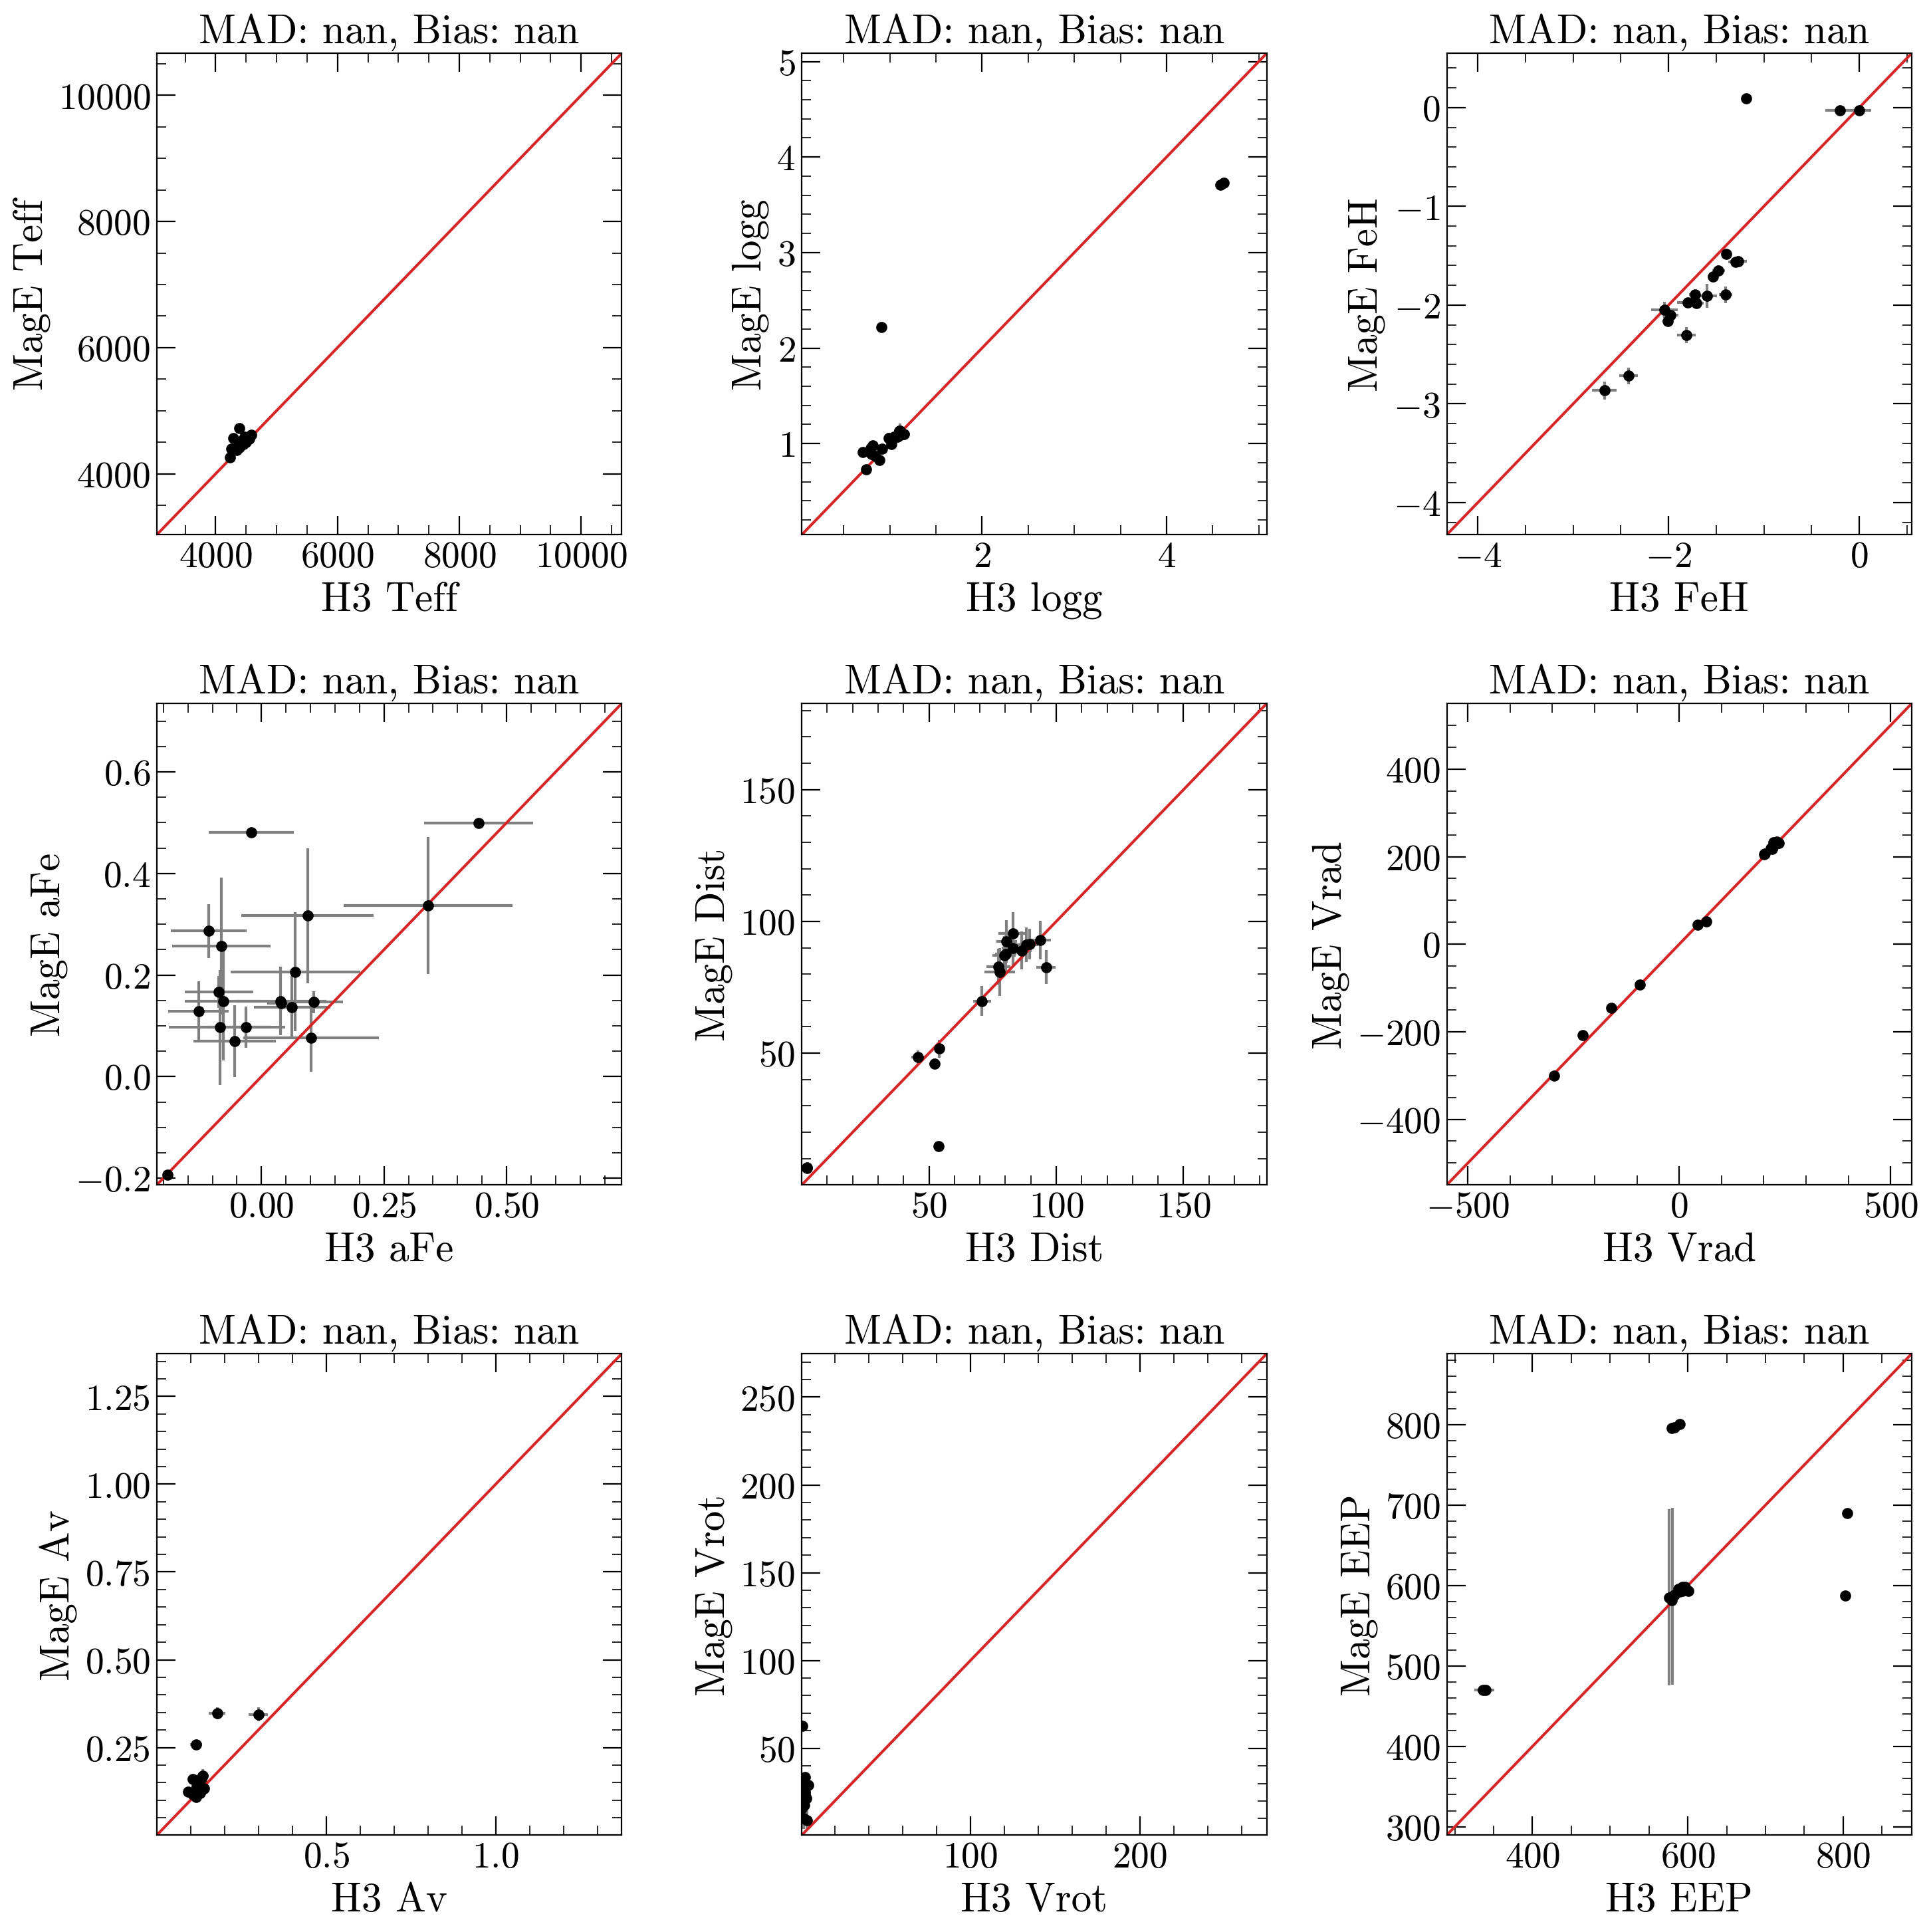

In [71]:
f,axs = plt.subplots(3,3,figsize = (15, 15))
axr = axs.ravel()

labels = ['Teff', 'logg', 'FeH', 'aFe', 'Dist', 'Vrad', 'Av', 'Vrot', 'EEP']

for ii in range(len(labels)):
    plt.sca(axr[ii])
    comp(labels[ii])
    
    plt.xlabel('H3 ' + labels[ii], fontsize = fs)
    plt.ylabel('MagE ' + labels[ii], fontsize = fs)
    
plt.tight_layout()

In [72]:
table[clean][np.abs((table['Vrad'][clean] - table['h3_Vrad'][clean])) > 5]

name,date,specfile,mage_ra,mage_dec,mage_target,mage_decker,mage_binning,mage_mjd,mage_airmass,mage_exptime,tdb_source_id,tdb_ra,tdb_dec,tdb_selection,H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,GAIAEDR3_ID,GAIADR1_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,UNWISE_W1,UNWISE_W2,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,WISE_CC_FLAGS,WISE_EXT_FLAG,ACAT_ID,EEP,EEP_lerr,EEP_uerr,EEP_err,init_FeH,init_FeH_lerr,init_FeH_uerr,init_FeH_err,init_aFe,init_aFe_lerr,init_aFe_uerr,init_aFe_err,init_Mass,init_Mass_lerr,init_Mass_uerr,init_Mass_err,pc_0,pc_0_lerr,pc_0_uerr,pc_0_err,pc_1,pc_1_lerr,pc_1_uerr,pc_1_err,pc_2,pc_2_lerr,pc_2_uerr,pc_2_err,pc_3,pc_3_lerr,pc_3_uerr,pc_3_err,Inst_R,Inst_R_lerr,Inst_R_uerr,Inst_R_err,Teff,Teff_lerr,Teff_uerr,Teff_err,logg,logg_lerr,logg_uerr,logg_err,logR,logR_lerr,logR_uerr,logR_err,FeH,FeH_lerr,FeH_uerr,FeH_err,aFe,aFe_lerr,aFe_uerr,aFe_err,Vrad,Vrad_lerr,Vrad_uerr,Vrad_err,Vrot,Vrot_lerr,Vrot_uerr,Vrot_err,Dist,Dist_lerr,Dist_uerr,Dist_err,Av,Av_lerr,Av_uerr,Av_err,logAge,logAge_lerr,logAge_uerr,logAge_err,Mass,Mass_lerr,Mass_uerr,Mass_err,logL,logL_lerr,logL_uerr,logL_err,Para,Para_lerr,Para_uerr,Para_err,Age,Age_lerr,Age_uerr,Age_err,lnZ,lnL,lnP,chisq_spec,nspecpix,chisq_phot,nbands,spec_snr,R_gal,R_gal_err,X_gal,X_gal_err,Y_gal,Y_gal_err,Z_gal,Z_gal_err,Vx_gal,Vx_gal_err,Vy_gal,Vy_gal_err,Vz_gal,Vz_gal_err,Vr_gal,Vr_gal_err,Vphi_gal,Vphi_gal_err,Vtheta_gal,Vtheta_gal_err,V_tan,V_tan_err,V_gsr,V_gsr_err,Lx,Lx_err,Ly,Ly_err,Lz,Lz_err,Ltot,Ltot_err,E_kin_pot1,E_kin_pot1_err,E_pot_pot1,E_pot_pot1_err,E_tot_pot1,E_tot_pot1_err,circLz_pot1,circLz_pot1_err,circLtot_pot1,circLtot_pot1_err,FLAG,dup,Sgr_l,Sgr_b,Sgr_FLAG,year,h3_starname,h3_tileID,h3_selID,h3_dateID,h3_fibID,h3_redID,h3_pipeID,h3_H3_ID,h3_TMASS_ID,h3_GAIADR1_ID,h3_GAIADR2_ID,h3_GAIAEDR3_ID,h3_UNWISE_ID,h3_RA,h3_DEC,h3_RA_S,h3_DEC_S,h3_GAIADR2_RA,h3_GAIADR2_RA_ERROR,h3_GAIADR2_DEC,h3_GAIADR2_DEC_ERROR,h3_GAIAEDR3_RA,h3_GAIAEDR3_RA_ERROR,h3_GAIAEDR3_DEC,h3_GAIAEDR3_DEC_ERROR,h3_L,h3_B,h3_xfocal,h3_yfocal,h3_CCDTEMP,h3_mjd,h3_night,h3_RAND,h3_GUIDE,h3_XFIT_RANK,h3_MGIANT,h3_BHB,h3_EBV,h3_APOPAYNE_RA,h3_APOPAYNE_DEC,h3_APOPAYNE_ID,h3_APOPAYNE_TEFF,h3_APOPAYNE_LOGG,h3_APOPAYNE_VMIC,h3_APOPAYNE_VMAC,h3_APOPAYNE_FEH,h3_APOPAYNE_CH,h3_APOPAYNE_NH,h3_APOPAYNE_OH,h3_APOPAYNE_MGH,h3_APOPAYNE_ALH,h3_APOPAYNE_SIH,h3_APOPAYNE_SH,h3_APOPAYNE_KH,h3_APOPAYNE_CAH,h3_APOPAYNE_TIH,h3_APOPAYNE_CRH,h3_APOPAYNE_MNH,h3_APOPAYNE_NIH,h3_APOPAYNE_CUH,h3_APOPAYNE_C12C13,h3_APOPAYNE_CHI2_R,h3_APOPAYNE_QUALITY_FLAG,h3_APOPAYNE_DMATCH,h3_APODR17_ID,h3_APODR17_RA,h3_APODR17_DEC,h3_APODR17_SNR,h3_APODR17_TEFF,h3_APODR17_TEFF_ERR,h3_APODR17_LOGG,h3_APODR17_LOGG_ERR,h3_APODR17_FEH,h3_APODR17_FEH_ERR,h3_APODR17_AFE,h3_APODR17_AFE_ERR,h3_APODR17_MGFE,h3_APODR17_MGFE_ERR,h3_APODR17_RV,h3_APODR17_RV_ERR,h3_APODR17_RV_SCATTER,h3_LAMOST_RA,h3_LAMOST_DEC,h3_LAMOST_ID,h3_LAM

### Calibration DGs

In [73]:
cra2 = (mage['tdb_selection'] == 'cra2')

sxt = (mage['tdb_selection'] == 'sxt')

print(np.sum(cra2), np.sum(sxt))

5 15


In [74]:
mage[cra2]

name,date,specfile,mage_ra,mage_dec,mage_target,mage_decker,mage_binning,mage_mjd,mage_airmass,mage_exptime,tdb_source_id,tdb_ra,tdb_dec,tdb_selection,H3_ID,PS_ID,TMASS_ID,WISE_ID,UNWISE_ID,GAIAEDR3_ID,GAIADR1_ID,TILE_ID,RA,DEC,RA_S,DEC_S,L,B,EBV,BHB,MGIANT,RAND,GUIDE,XFIT_RANK,PS_G,PS_R,PS_I,PS_Z,PS_Y,SDSS_U,SDSS_G,SDSS_R,SDSS_I,SDSS_Z,TMASS_J,TMASS_H,TMASS_K,WISE_W1,WISE_W2,UNWISE_W1,UNWISE_W2,GAIAEDR3_G,GAIAEDR3_BP,GAIAEDR3_RP,PS_G_ERR,PS_R_ERR,PS_I_ERR,PS_Z_ERR,PS_Y_ERR,SDSS_U_ERR,SDSS_G_ERR,SDSS_R_ERR,SDSS_I_ERR,SDSS_Z_ERR,TMASS_J_ERR,TMASS_H_ERR,TMASS_K_ERR,WISE_W1_ERR,WISE_W2_ERR,UNWISE_W1_ERR,UNWISE_W2_ERR,GAIAEDR3_G_ERR,GAIAEDR3_BP_ERR,GAIAEDR3_RP_ERR,GAIAEDR3_RA,GAIAEDR3_DEC,GAIAEDR3_RA_ERROR,GAIAEDR3_DEC_ERROR,GAIAEDR3_PARALLAX,GAIAEDR3_PARALLAX_ERROR,GAIAEDR3_PARALLAX_OVER_ERROR,GAIAEDR3_PMRA,GAIAEDR3_PMDEC,GAIAEDR3_PMRA_ERROR,GAIAEDR3_PMDEC_ERROR,GAIAEDR3_PSEUDOCOLOUR,GAIAEDR3_PSEUDOCOLOUR_ERROR,GAIAEDR3_NU_EFF_USED_IN_ASTROMETRY,GAIAEDR3_ASTROMETRIC_PARAMS_SOLVED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR,GAIAEDR3_VISIBILITY_PERIODS_USED,GAIAEDR3_RUWE,GAIAEDR3_IPD_GOF_HARMONIC_AMPLITUDE,GAIAEDR3_G_CORRECTED,GAIAEDR3_PARALLAX_CORRECTED,GAIAEDR3_PHOT_BP_RP_EXCESS_FACTOR_CORRECTED,GAIAEDR3_PARALLAX_PMRA_CORR,GAIAEDR3_PARALLAX_PMDEC_CORR,GAIAEDR3_PMRA_PMDEC_CORR,GAIAEDR3_RA_DEC_CORR,GAIAEDR3_RA_PARALLAX_CORR,GAIAEDR3_RA_PMRA_CORR,GAIAEDR3_RA_PMDEC_CORR,GAIAEDR3_DEC_PARALLAX_CORR,GAIAEDR3_DEC_PMRA_CORR,GAIAEDR3_DEC_PMDEC_CORR,WISE_CC_FLAGS,WISE_EXT_FLAG,ACAT_ID,EEP,EEP_lerr,EEP_uerr,EEP_err,init_FeH,init_FeH_lerr,init_FeH_uerr,init_FeH_err,init_aFe,init_aFe_lerr,init_aFe_uerr,init_aFe_err,init_Mass,init_Mass_lerr,init_Mass_uerr,init_Mass_err,pc_0,pc_0_lerr,pc_0_uerr,pc_0_err,pc_1,pc_1_lerr,pc_1_uerr,pc_1_err,pc_2,pc_2_lerr,pc_2_uerr,pc_2_err,pc_3,pc_3_lerr,pc_3_uerr,pc_3_err,Inst_R,Inst_R_lerr,Inst_R_uerr,Inst_R_err,Teff,Teff_lerr,Teff_uerr,Teff_err,logg,logg_lerr,logg_uerr,logg_err,logR,logR_lerr,logR_uerr,logR_err,FeH,FeH_lerr,FeH_uerr,FeH_err,aFe,aFe_lerr,aFe_uerr,aFe_err,Vrad,Vrad_lerr,Vrad_uerr,Vrad_err,Vrot,Vrot_lerr,Vrot_uerr,Vrot_err,Dist,Dist_lerr,Dist_uerr,Dist_err,Av,Av_lerr,Av_uerr,Av_err,logAge,logAge_lerr,logAge_uerr,logAge_err,Mass,Mass_lerr,Mass_uerr,Mass_err,logL,logL_lerr,logL_uerr,logL_err,Para,Para_lerr,Para_uerr,Para_err,Age,Age_lerr,Age_uerr,Age_err,lnZ,lnL,lnP,chisq_spec,nspecpix,chisq_phot,nbands,spec_snr,R_gal,R_gal_err,X_gal,X_gal_err,Y_gal,Y_gal_err,Z_gal,Z_gal_err,Vx_gal,Vx_gal_err,Vy_gal,Vy_gal_err,Vz_gal,Vz_gal_err,Vr_gal,Vr_gal_err,Vphi_gal,Vphi_gal_err,Vtheta_gal,Vtheta_gal_err,V_tan,V_tan_err,V_gsr,V_gsr_err,Lx,Lx_err,Ly,Ly_err,Lz,Lz_err,Ltot,Ltot_err,E_kin_pot1,E_kin_pot1_err,E_pot_pot1,E_pot_pot1_err,E_tot_pot1,E_tot_pot1_err,circLz_pot1,circLz_pot1_err,circLtot_pot1,circLtot_pot1_err,FLAG,dup,Sgr_l,Sgr_b,Sgr_FLAG,year
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg2,,
bytes32,bytes10,bytes85,float64,float64,bytes11,bytes3,bytes3,float64,float64,float64,int64,float64,float64,bytes7,int32,int32,bytes17,bytes19,bytes16,int64,int32,bytes8,float64,float64,bytes11,bytes12,float64,float64,float64,int16,int16,float64,int16,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes4,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [75]:
cray = np.repeat(5.5, np.sum(cra2)) + np.linspace(0, 1, np.sum(cra2))
sxty = np.repeat(5.5, np.sum(sxt)) + np.linspace(0, 1, np.sum(sxt))

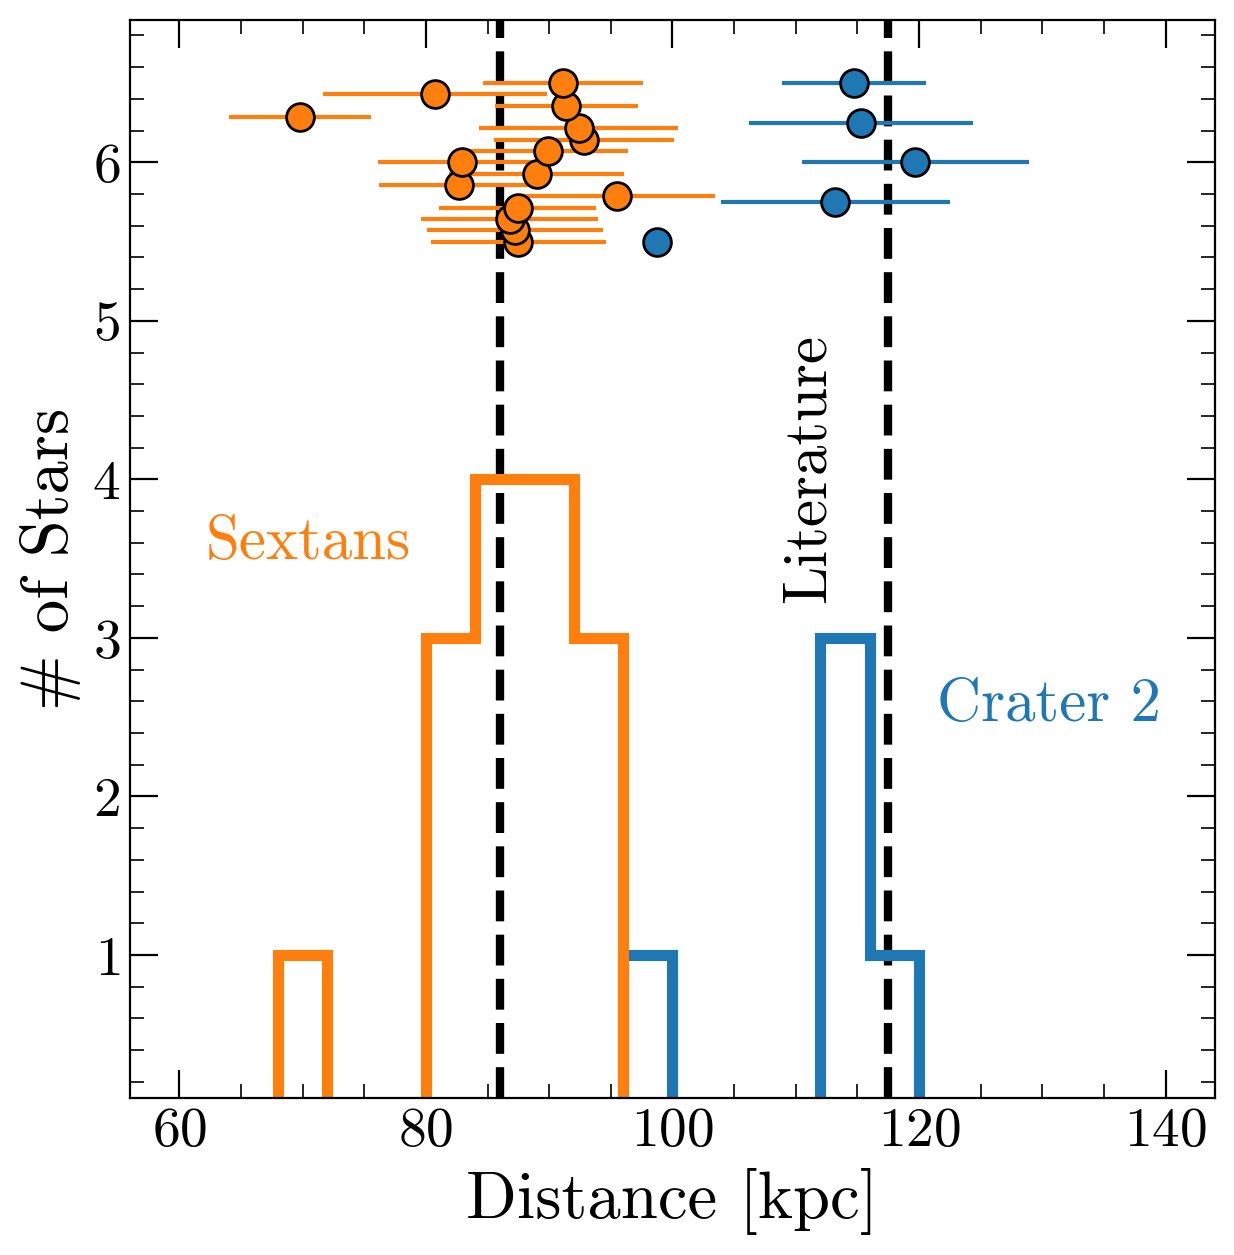

In [76]:
hkw = dict(histtype = 'step', lw = 4, bins = 20, range = (60, 140))

plt.hist(mage[cra2]['Dist'], density = False, label = 'Crater 2',
        **hkw);
plt.hist(mage[sxt]['Dist'], density = False, label = 'Sextans',
        **hkw);
plt.axvline(86, color = 'k', lw = 3, ls = '--', label = 'Lit. Distance', zorder = 0)
plt.axvline(117.5, color = 'k', lw = 3, ls = '--', zorder = 0)

plt.errorbar(mage[cra2]['Dist'], cray, xerr = mage[cra2]['Dist_err'],
            linestyle = 'none', color = 'C0', capsize = 0, marker = 'o', markersize = 10, mec = 'k')
 
plt.errorbar(mage[sxt]['Dist'], sxty, xerr = mage[sxt]['Dist_err'],
            linestyle = 'none', color = 'C1', capsize = 0, marker = 'o', markersize = 10, mec = 'k')


plt.text(0.07, .5, 'Sextans', color = 'C1', transform = plt.gca().transAxes)
plt.text(0.95, .35, 'Crater 2', color = 'C0', transform = plt.gca().transAxes, ha = 'right')

plt.text(0.6, .47, 'Literature', color = 'k', transform = plt.gca().transAxes, ha = 'left',
        rotation = 90)


plt.ylim(0.1, 6.9)
plt.ylabel('# of Stars')
plt.xlabel('Distance [kpc]')

plt.savefig('/Users/vedantchandra/0_research/00_outerhalo/06_mage/01_plume/fig/dval.pdf')

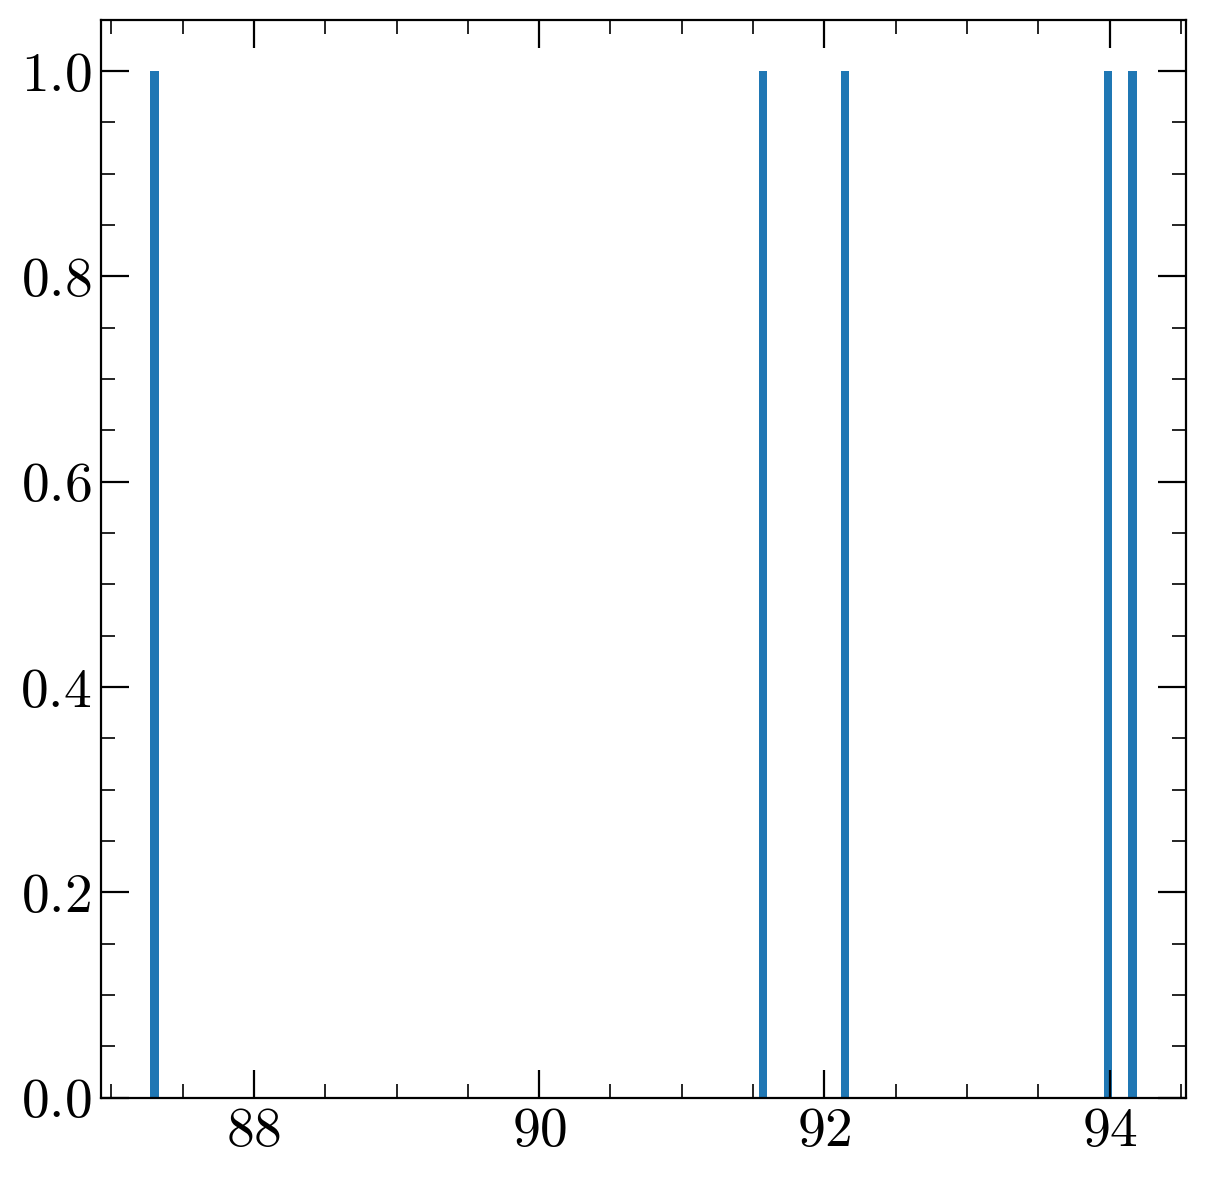

In [77]:
plt.hist(mage[cra2]['Vrad'], bins = 120);

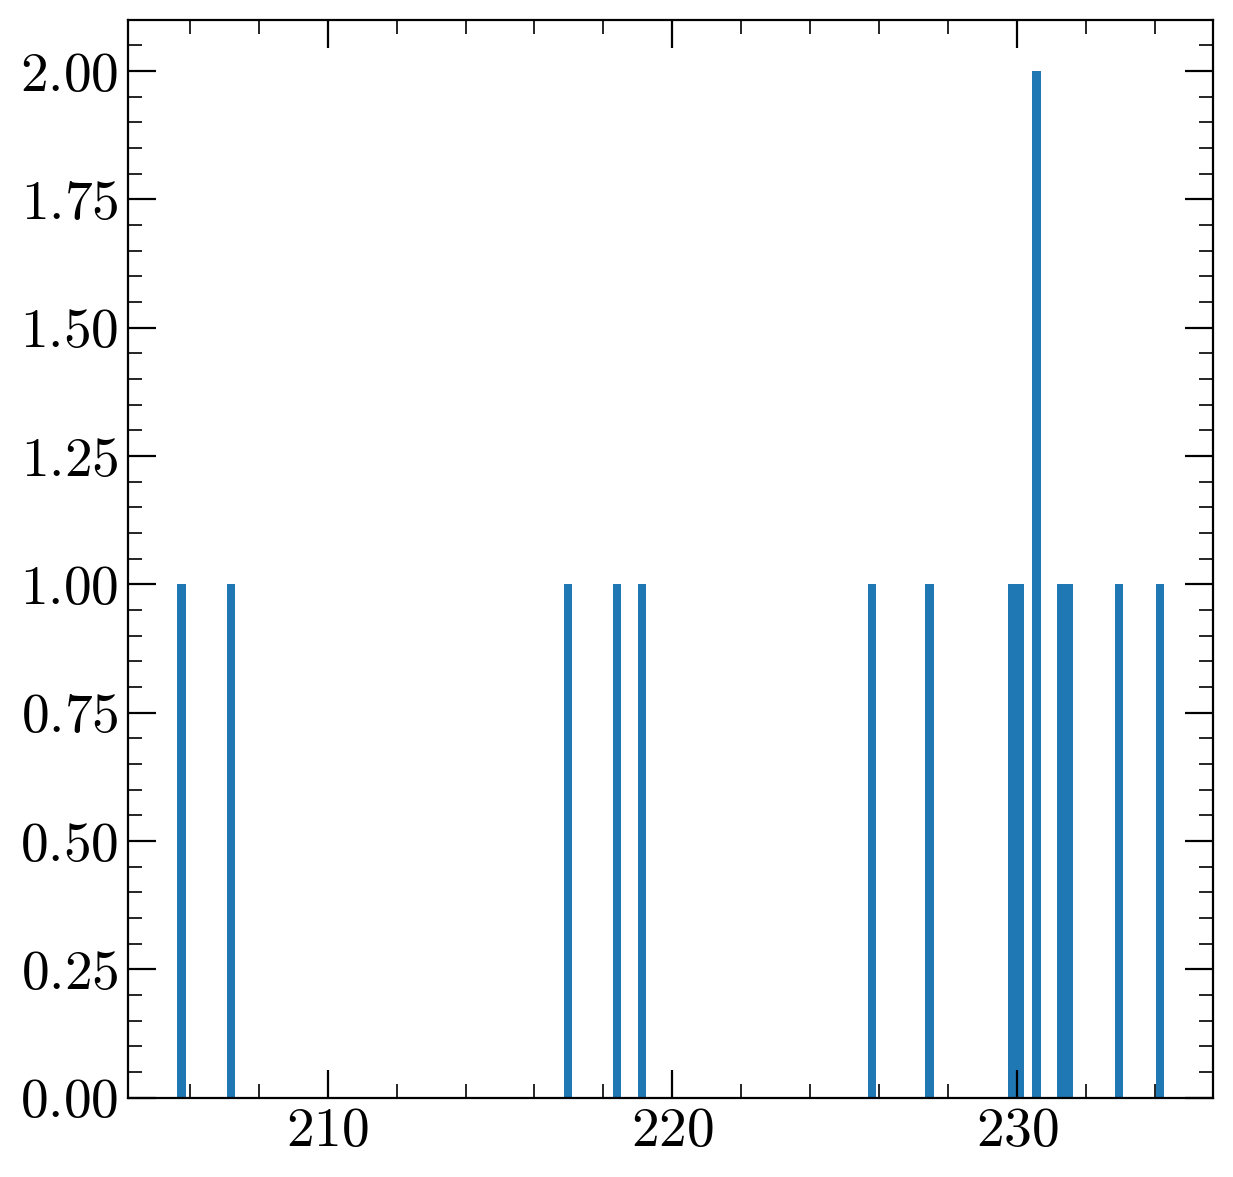

In [78]:
plt.hist(mage[sxt]['Vrad'], bins = 120);

In [79]:
np.average(mage[cra2]['Dist'], weights = 1 / mage[cra2]['Dist_err']**2)

100.11685959178129

In [80]:
np.sqrt(1 / np.sum(1 / mage[cra2]['Dist_err']**2))

1.1177529883313073

In [81]:
np.average(mage[sxt]['Dist'], weights = 1 / mage[sxt]['Dist_err']**2)

86.70017452157205

In [82]:
np.sqrt(1 / np.sum(1 / mage[sxt]['Dist_err']**2))

1.7698185363787104

Text(0, 0.5, '# of stars')

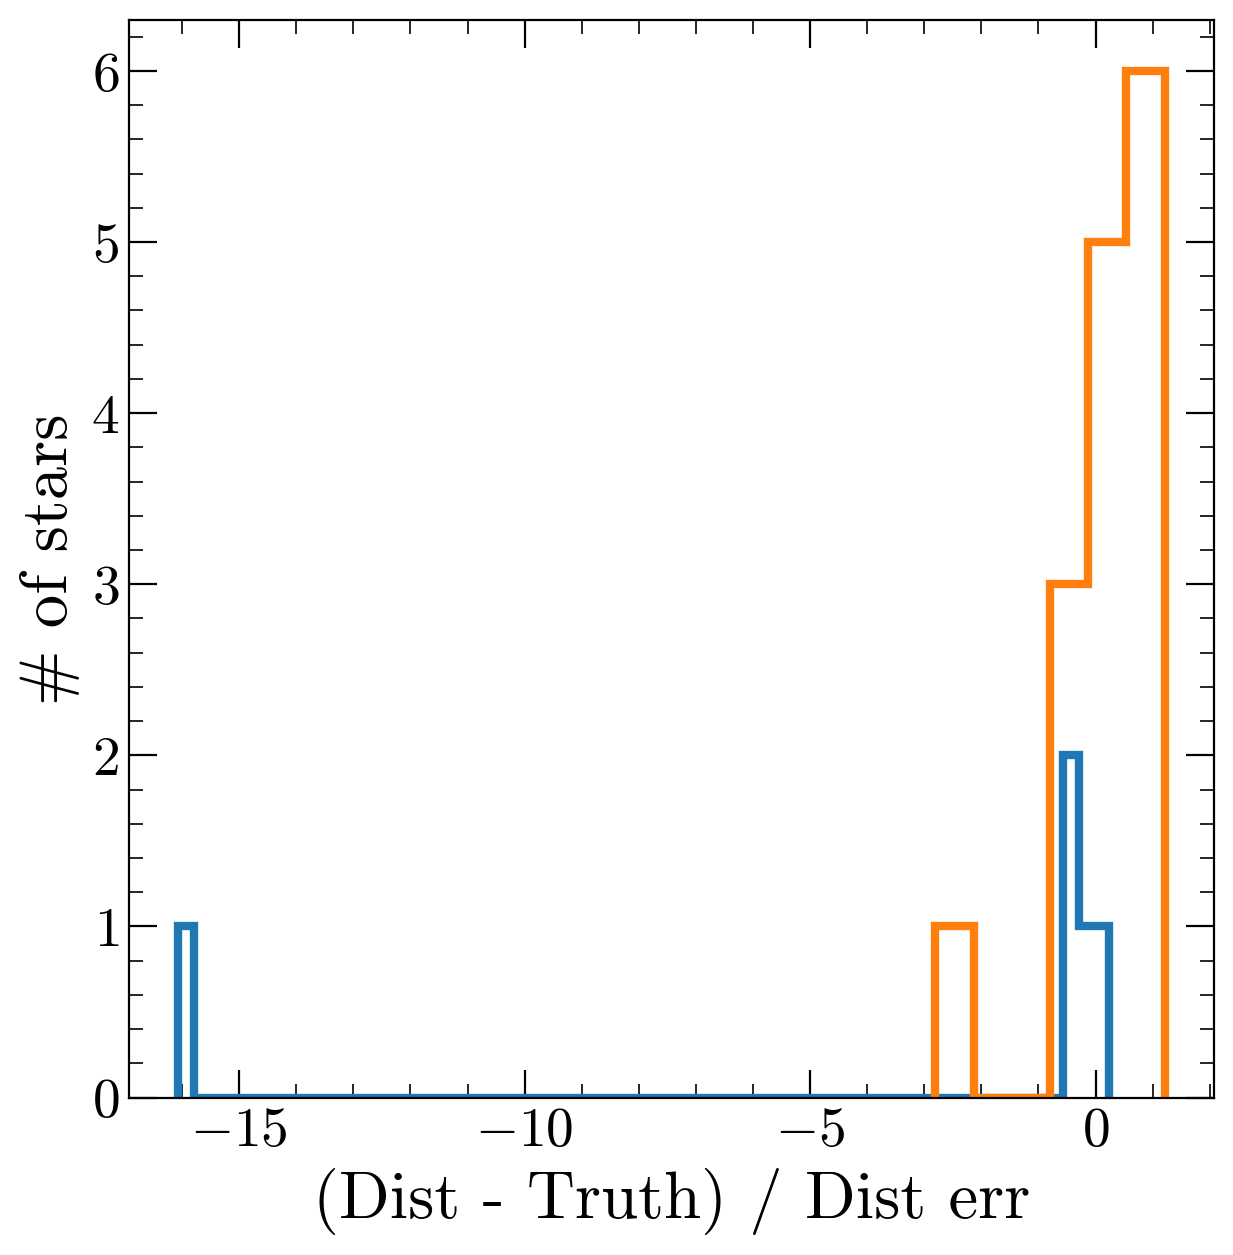

In [83]:
plt.hist((mage[cra2]['Dist'] - 117.5) / mage[cra2]['Dist_err'],
        histtype = 'step', lw = 3, label = 'Crater2')

plt.hist((mage[sxt]['Dist'] - 86) / mage[sxt]['Dist_err'],
        histtype = 'step', lw = 3, label = 'Sextans')

plt.xlabel('(Dist - Truth) / Dist err')

plt.ylabel('# of stars')

In [84]:
np.abs((mage[cra2]['Dist'] - 117.5) / mage[cra2]['Dist_err'])

16.066346987946908
0.46327820696510286
0.2396856224029083
0.242703679876882
0.47139342625150293


In [85]:
np.sum(np.abs((mage[sxt]['Dist'] - 86.0) / mage[sxt]['Dist_err']) < 1)

13

In [86]:
9 / np.sum(sxt)

0.6

In [87]:
np.sum(np.abs((mage[sxt]['Dist'] - 86.0) / mage[sxt]['Dist_err']) < 2.5)

14

### RVS

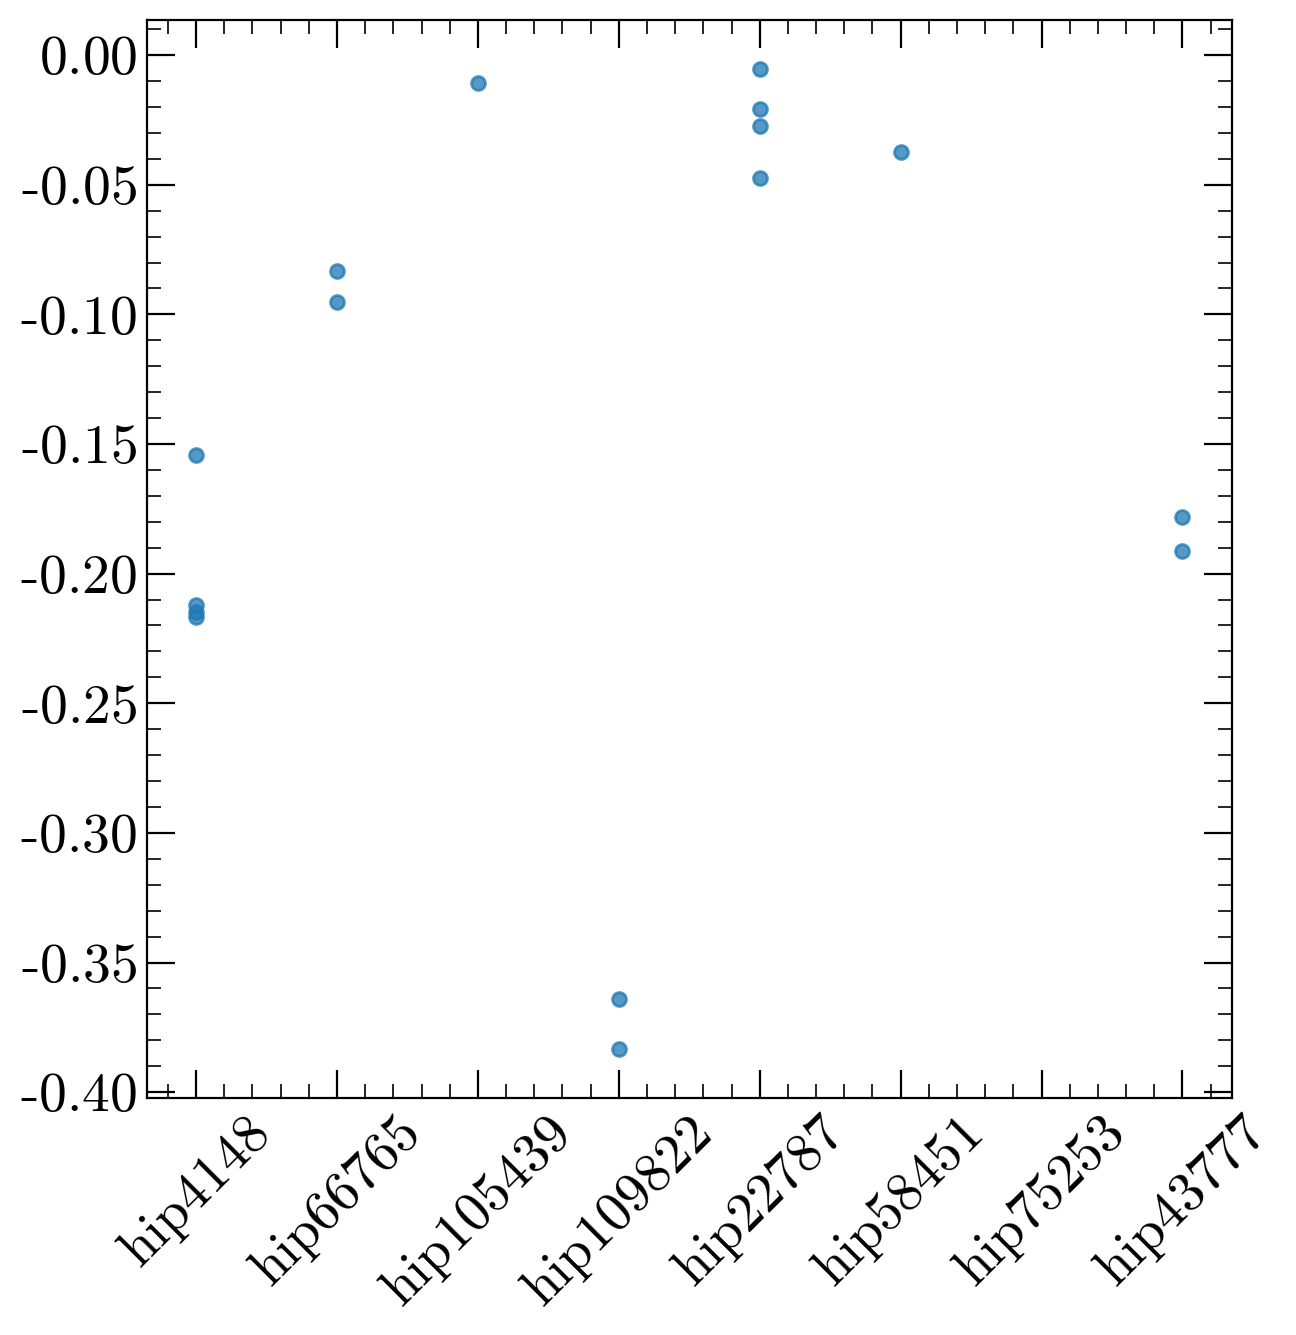

In [189]:
plt.scatter(rvs['name'], rvs['FeH'], alpha = 0.75)
plt.xticks(rotation=45);

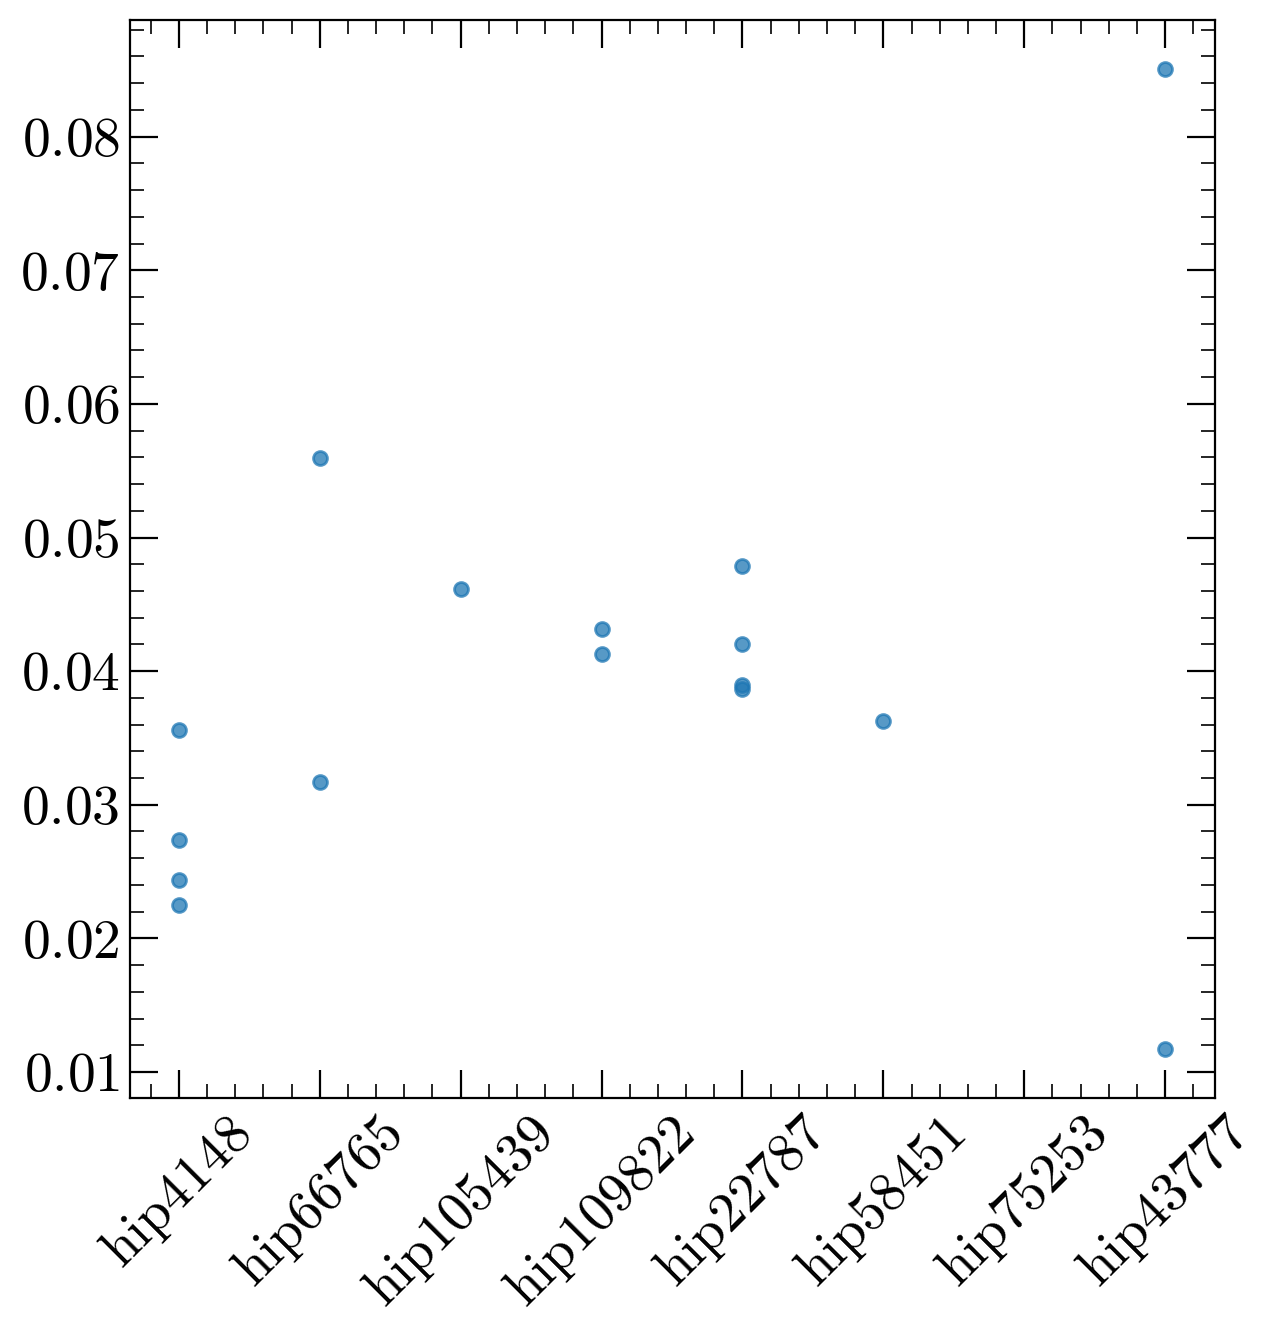

In [190]:
plt.scatter(rvs['name'], rvs['Vrad_err'], alpha = 0.75)
plt.xticks(rotation=45);

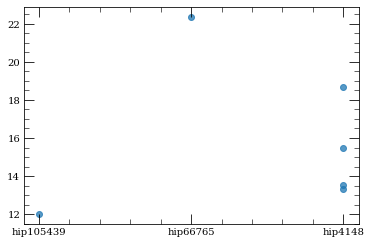

In [19]:
plt.scatter(tab['name'], tab['Vrot'], alpha = 0.75)

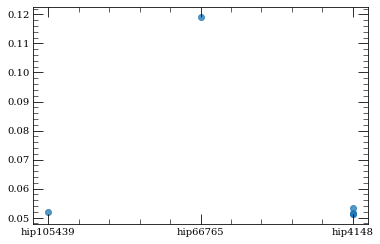

In [20]:
plt.scatter(tab['name'], tab['Av'], alpha = 0.75)